Для аналізу факторів будемо використовувати схему валідації з ноутбуку команди AfterParty (https://www.kaggle.com/yakuben/softservehackathon-afterparty-solution), тобто тренувати модель на 4х місяцях і тестувати на 1 місяці з проміжком 2 місяці (У своїй моделі ми також використовували random forest, однак схема валідації гірша.)

Для аналізу результатів моделі будемо використовувати бібліотеку shap, яка працює з Tree-based models.
https://christophm.github.io/interpretable-ml-book/shap.html

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
import numpy as np
import pandas as pd
import shap
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [0]:
employees_data = pd.read_csv('../input/softserve-ds-hackathon-2020/employees.csv', parse_dates=['HiringDate', 'DismissalDate'])
history_data = pd.read_csv('../input/softserve-ds-hackathon-2020/history.csv', parse_dates=['Date'])

In [0]:
df = history_data.merge(employees_data, how='outer', on='EmployeeID')
df['months_to_dissmiss'] = (df['DismissalDate'].sub(df['Date']) / np.timedelta64(1, 'M')).round()
df['target'] = (df['months_to_dissmiss'] <= 3).astype(int)
df['experience_months'] = (df['Date'].sub(df['HiringDate']) / np.timedelta64(1, 'M')).round()

df['ProjectID'] = df['ProjectID'].fillna('other')

# drop those who had experience less than 3 months (cause all guys from 2019-02-01 have already worked 3 months)
df = df[df['experience_months'] >= 4].reset_index(drop=True)

# drop those who worked after dismissal
df.drop(df[df['Date'] >= df['DismissalDate']].index, inplace=True)

In [0]:
le = LabelEncoder()
df['ProjectID'] = le.fit_transform(df['ProjectID'].astype(str))
df['CustomerID'] = le.fit_transform(df['CustomerID'].astype(str))

In [0]:
val_date = '2018-11-01'
train_date = ['2018-05-01', '2018-08-01']

val = df[df['Date'] == val_date]
train = df[(df['Date'] >= train_date[0]) & (df['Date'] <= train_date[1])].reset_index(drop=True)

In [0]:
drop_cols = ['Date','EmployeeID', 'months_to_dissmiss', 'DismissalDate', 'HiringDate']

val = val.drop(columns = drop_cols)
X_val = val.drop('target', axis=1)
y_val = val['target']

train = train.drop(columns = drop_cols)
X_train = train.drop('target', axis=1)
y_train = train['target']

In [0]:
def validate_model(model, X_val, y_val, threshold = 0.4, verbose=1):
    y_pred = model.predict_proba(X_val)[:, 1] > threshold
    score = fbeta_score(y_val, y_pred, 1.7)
    if verbose:
        print("mean target result: ", y_pred.mean())
        print("score: ", score)
    return score, y_pred

In [0]:
def variate_factor(factor, model, data, variation_range, n_samples=100, random_state=1):
    sample_ones = data[data['target'] == 1].sample(n_samples, random_state=random_state)
    sample_zeros = data[data['target'] == 0].sample(n_samples, random_state=random_state)
    sample = pd.concat((sample_zeros, sample_ones))
    
    variation_values = []
    prediction_means = []
    
    for value in variation_range:
        sample_copy = sample.copy()
        sample_copy[factor] += value
        
        _, y_pred = validate_model(model, sample_copy.drop('target', axis=1), sample_copy['target'], verbose=0)
        
        variation_values.append((str(value.round(2)) if value <=0 else '+'+str(value.round(2))))
        prediction_means.append(y_pred[y_pred == 1].sum())
    
    plt.plot(variation_values, prediction_means)
    plt.title('Impact of "'+factor+'" on prediction')
    plt.xlabel('variation of ' + factor)
    plt.ylabel('predicted # of guys who dismiss')
    plt.show()

In [0]:
def plot_misclass_hist(df, feature, bins=35, figsize=(15, 5)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(feature)
    ax1.set_title('target = 0')
    ax2.set_title('target = 1')
    ax1.hist([df.loc[(df['pred_target'] == 0) & (df['true_target'] == 0), feature],
             df.loc[(df['pred_target'] == 1) & (df['true_target'] == 0), feature]],
             stacked=True,
             label=['pred = 0', 'pred = 1'],
             bins=bins)
    ax2.hist([df.loc[(df['pred_target'] == 1) & (df['true_target'] == 1), feature],
             df.loc[(df['pred_target'] == 0) & (df['true_target'] == 1), feature]],
             stacked=True,
             label=['pred = 1', 'pred = 0'],
             bins=bins)
    ax1.legend()
    ax2.legend()


In [0]:
def plot_misclass_count(df, feature, figsize=(15, 5)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(feature)
    
    ax1.set_title('target = 0')
    ax2.set_title('target = 1')
    
    pd.crosstab(df.loc[df['true_target'] == 0, feature], 
                df.loc[df['true_target'] == 0, 'pred_target']).plot.bar(stacked=True, ax=ax1)
    pd.crosstab(df.loc[df['true_target'] == 1, feature], 
                df.loc[df['true_target'] == 1, 'pred_target'])[[1, 0]].plot.bar(stacked=True, ax=ax2)

In [0]:
model = RandomForestClassifier(n_estimators=100, 
                             class_weight='balanced',
                             max_leaf_nodes=64,
                             max_depth=12,
                             max_features=5, 
                             min_samples_split=5, 
                             min_samples_leaf=3,
                             criterion='gini',
                             n_jobs=-1,
                             random_state=1)

In [0]:
model.fit(X_train, y_train)
score, y_pred = validate_model(model, X_val, y_val);

mean target result:  0.31010701545778835
score:  0.2382105658045723


In [0]:
val_with_pred = val.copy().rename(columns={'target':'true_target'})
val_with_pred['pred_target'] = y_pred

In [0]:
import shap
model.fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


## Dismissal risk drivers

### Сила впливу факторів

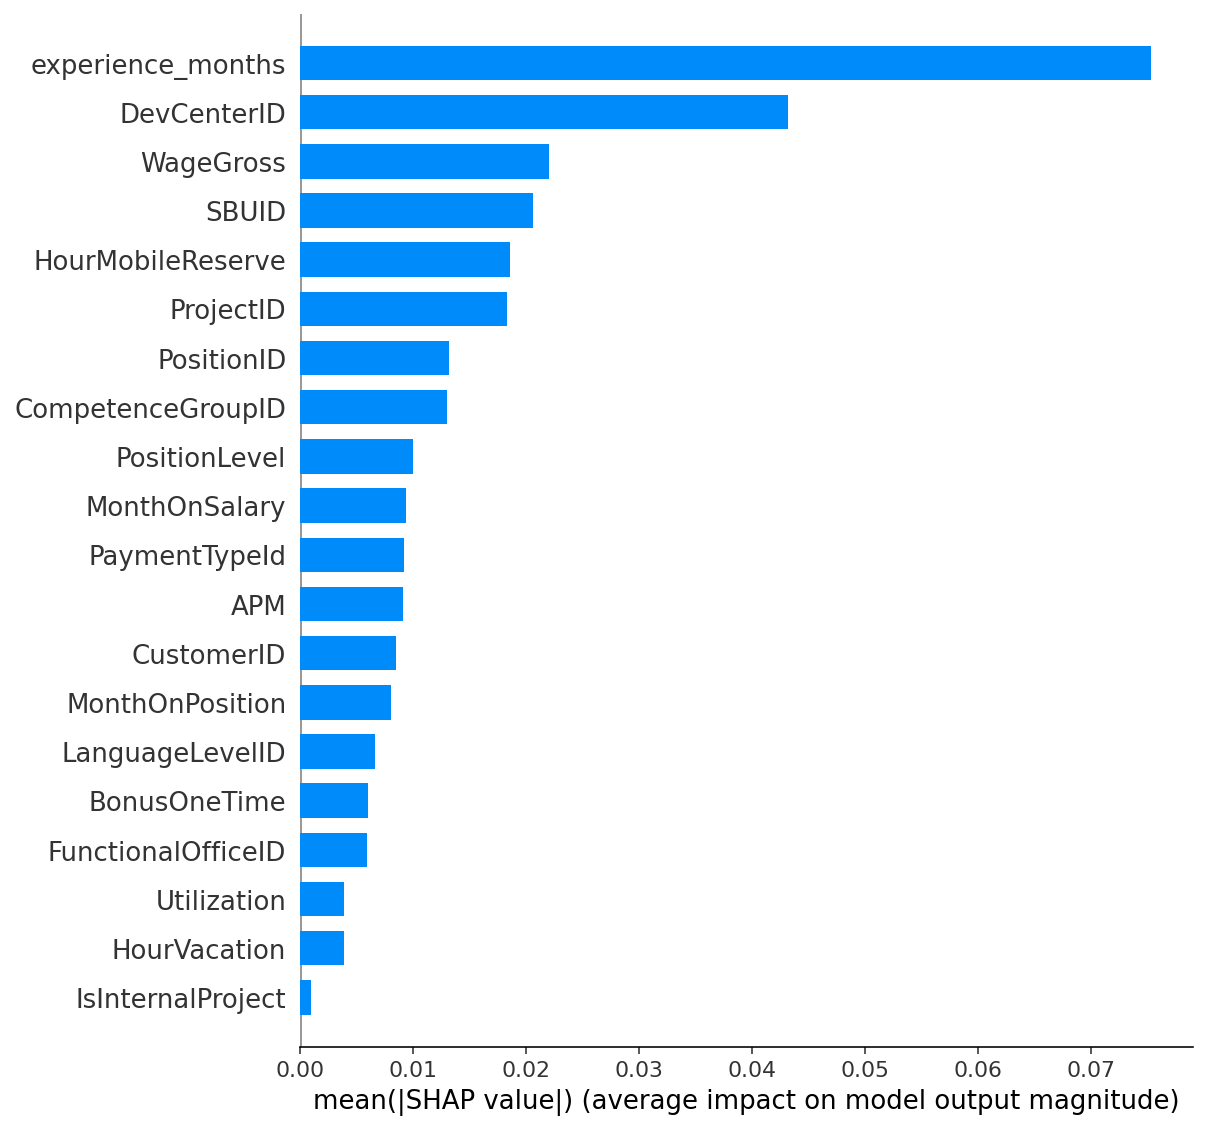

In [0]:
shap.summary_plot(shap_values[1], X_train, plot_type='bar')

### Вплив факторів на рішення моделі

Кожна точка - один семпл з даних.

SHAP-value (по горизонталі) показують вплив наявності певного атрибуту (feature) порівняно з прогнозом, 
який ми зробили б, якби цей атрибут приймав деяке базове значення (SHAP = 0).

Розташування точки ближче до правого краю означає, що даний фактор мав позитивний вплив на dismissal 
(тобто для даного семплу чим більше фактор, тим більша ймовірність dismissal), ближче до лівого - негативний вплив.

Колір точки показує саме значення фактору даного семпла (червоні - більші значення).

Фактори відсортовані по їхньому впливу на кінцеве рішення.

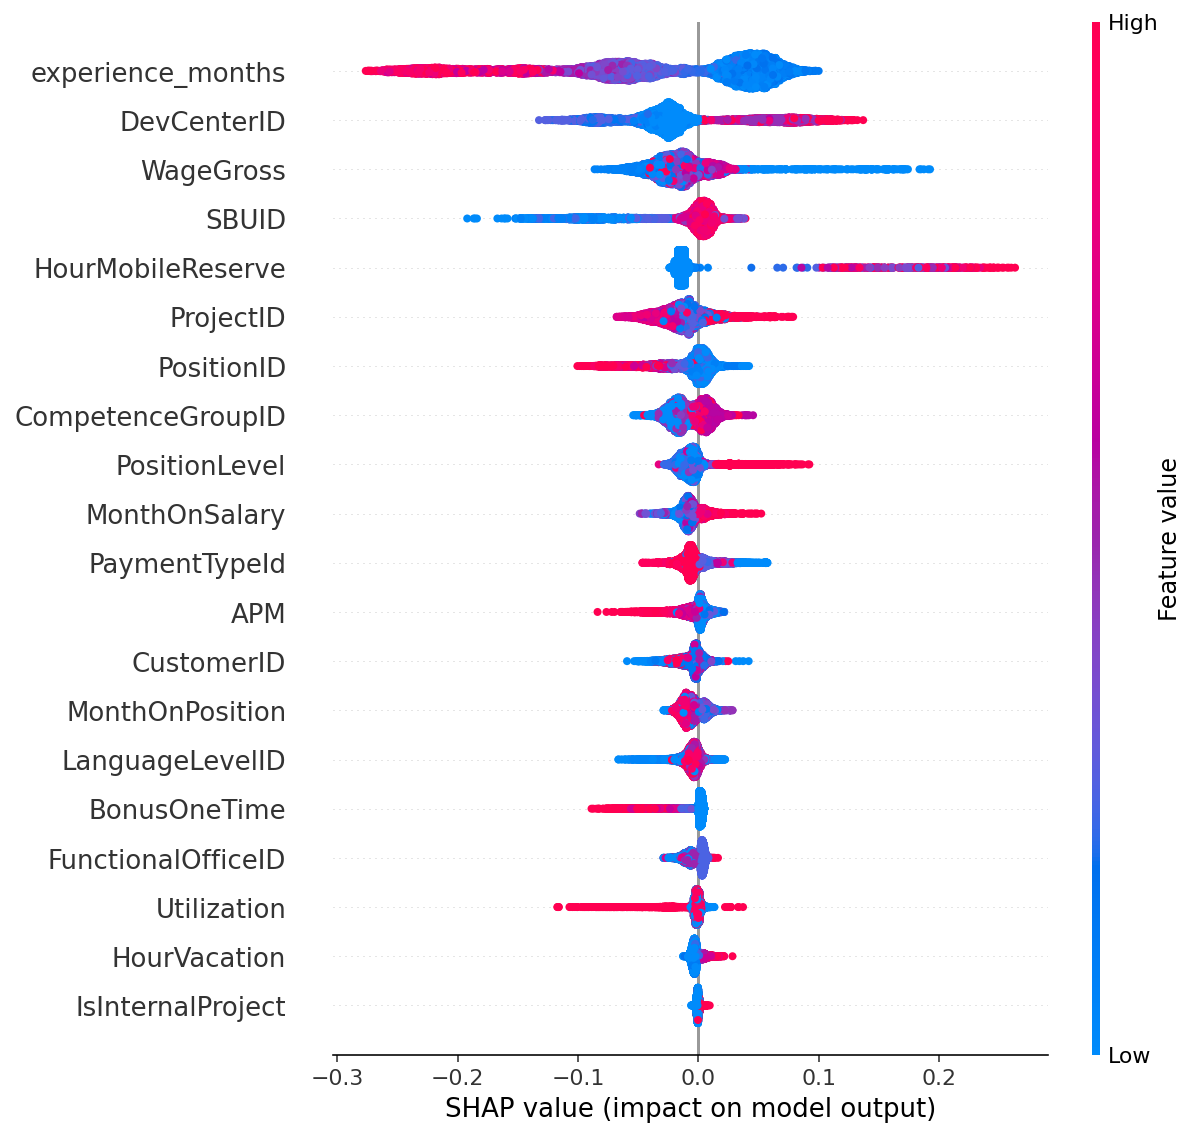

In [0]:
shap.summary_plot(shap_values[1], X_train)

In [0]:
SAMPLE_SIZE = 1000

#### Окремо по факторах

'experience_month' - стаж в місяцях; найбільш впривовий фактор.
Після 30-40 місяців стажу уходить дуже мало людей.

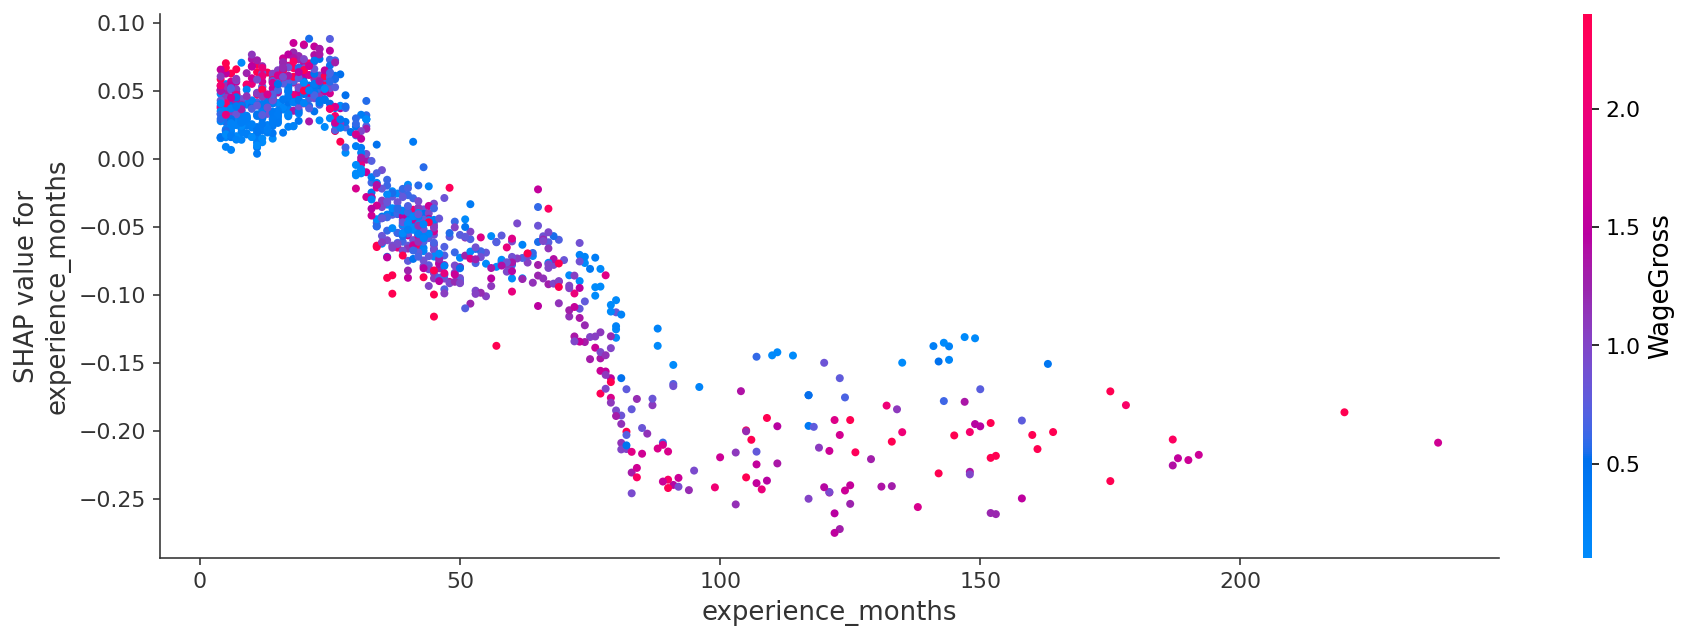

In [0]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
shap.dependence_plot('experience_months', 
                     pd.DataFrame(shap_values[1]).sample(SAMPLE_SIZE, random_state=1).values,
                     X_train.sample(SAMPLE_SIZE, random_state=1), 
                     interaction_index="WageGross", 
                     ax=ax1)

Подивимося як змінюються передбачення моделі зі збільшенням середнього значення фактору у валідаційній вибірці. 
Для цього виберем випадковим чином 100 семплів з ризиком і 100 без. Оригінальне передбачення моделі - 104 семпла з ризиком і 96 без.
При збільшенні середнього 'experience_months' на 20 місяців, модель передбачає всього 61 семпл з ризиком.

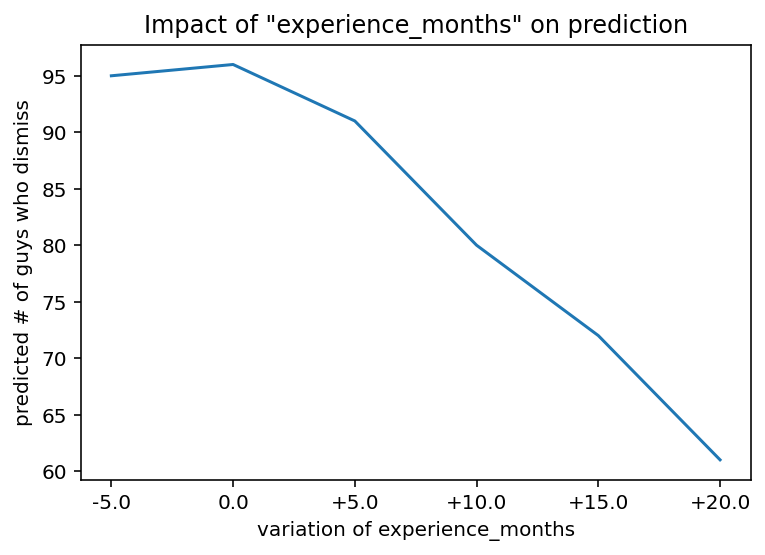

In [0]:
variate_factor('experience_months', model, val, np.linspace(-5, 20, 6))

Далі подивимось на розподіл коректно і некоректно класифікованих сеплів в обох категоріях (є ризик / немає), 
в залежності від значення фактору.
В даному випадку видно, що в даних дуже мало семплів "уход після 30 місяців", тому, хоч цей фактор мав велике значення на результат
передбачення моделі, ставити alert для менеджера по ньому не варто.

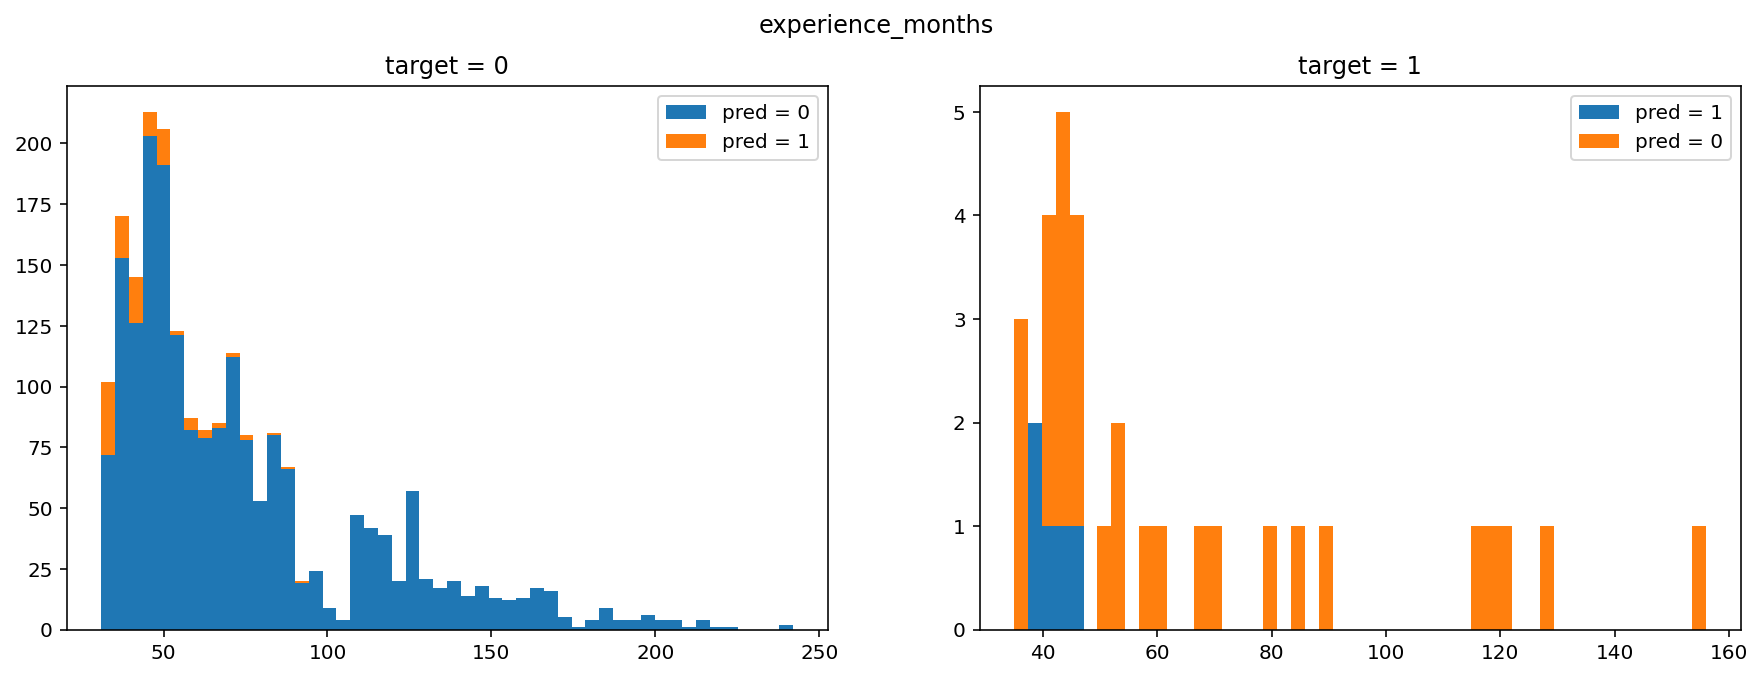

In [0]:
plot_misclass_hist(val_with_pred[val_with_pred['experience_months'] > 30], 'experience_months', bins=50)

**'DevCenterID'** - з центрів 1-5 менш схильні уходити (фактор втримання), після 7 навпаки. 

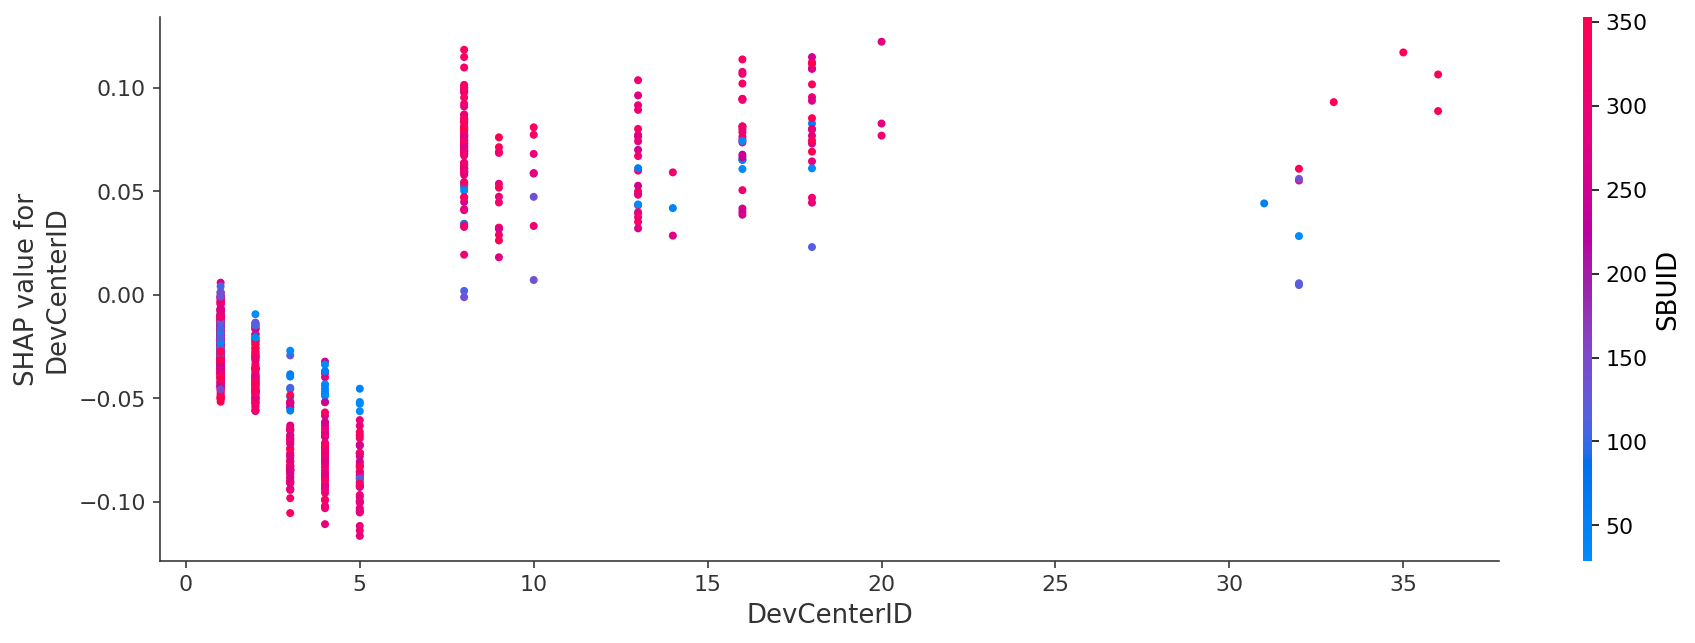

In [0]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
shap.dependence_plot('DevCenterID', 
                     pd.DataFrame(shap_values[1]).sample(SAMPLE_SIZE, random_state=1).values,
                     X_train.sample(SAMPLE_SIZE, random_state=1), 
                     interaction_index="SBUID", 
                     ax=ax1,
                     )

Видно що для перших кількох класів модель робить значну кількість помилок, тому як "фактор втримання" значення 1-5 краще не сприймати.
Однак для DevCenterID > 13 усі семпли з ризиком були коректно класифіковані - це можна приймати за надійний alert.

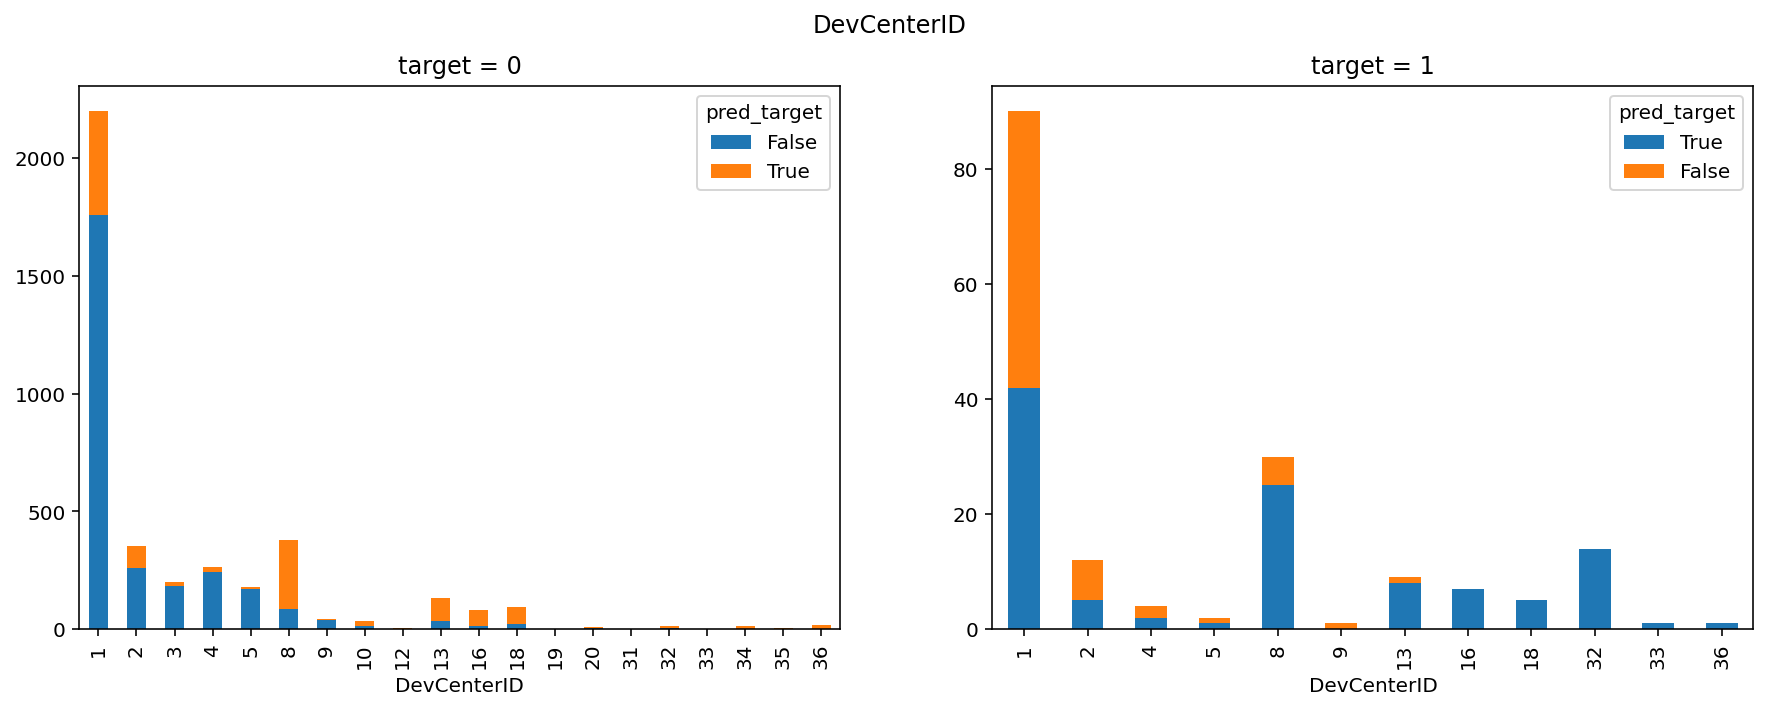

In [0]:
plot_misclass_count(val_with_pred, 'DevCenterID')

**'WageGross'** - в околі 0.25 - негативний вплив на dismissal

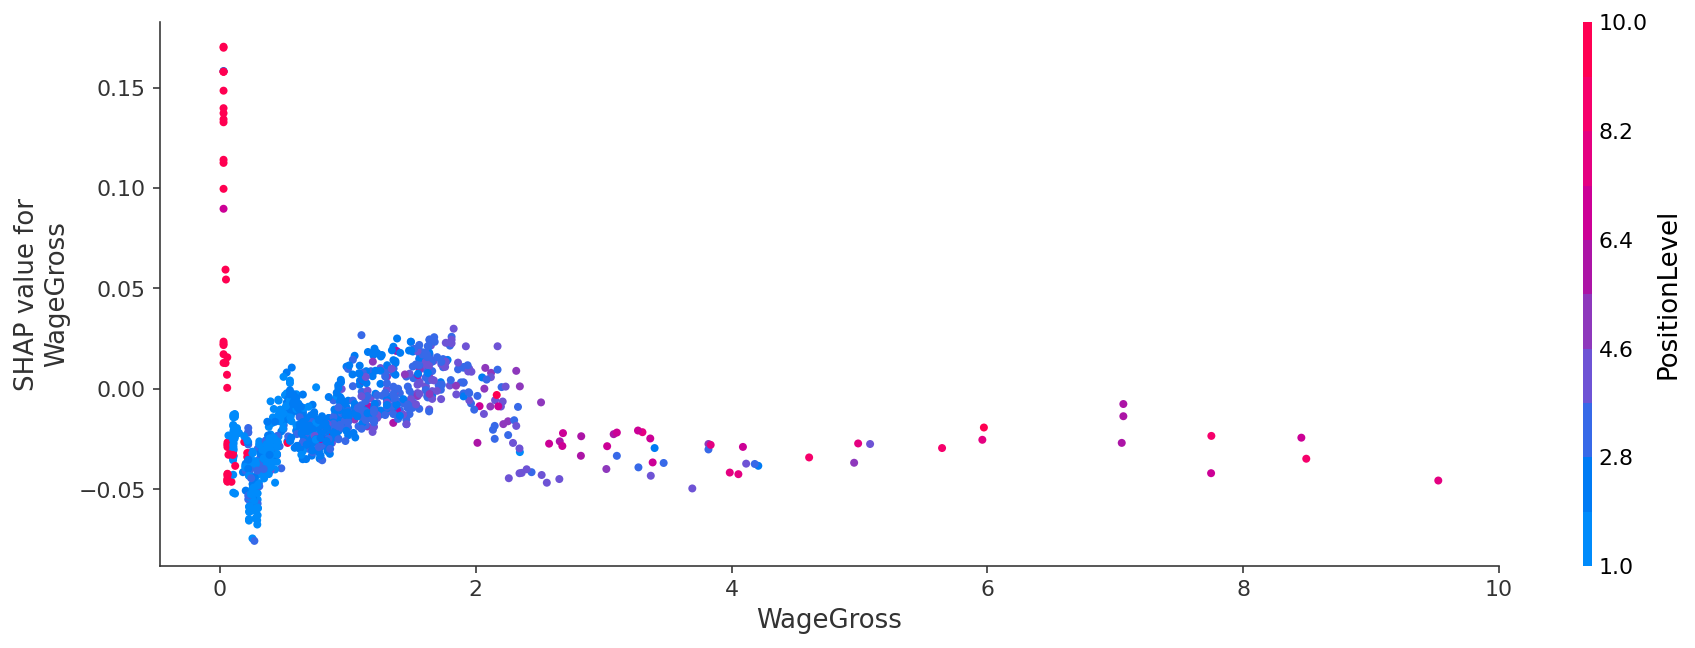

In [0]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
shap.dependence_plot('WageGross', 
                     pd.DataFrame(shap_values[1]).sample(SAMPLE_SIZE, random_state=1).values,
                     X_train.sample(SAMPLE_SIZE, random_state=1), 
                     interaction_index="PositionLevel", 
                     ax=ax1,
                     xmax=10)

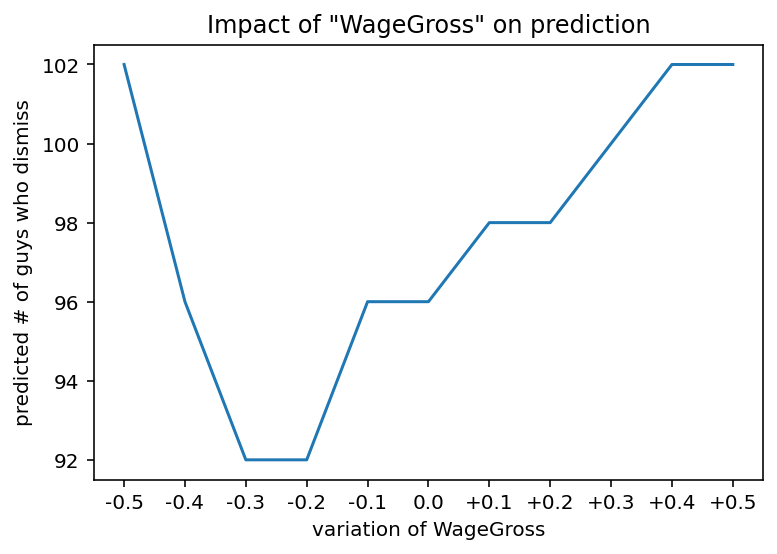

In [0]:
variate_factor('WageGross', model, val, np.linspace(-0.5, 0.5, 11))

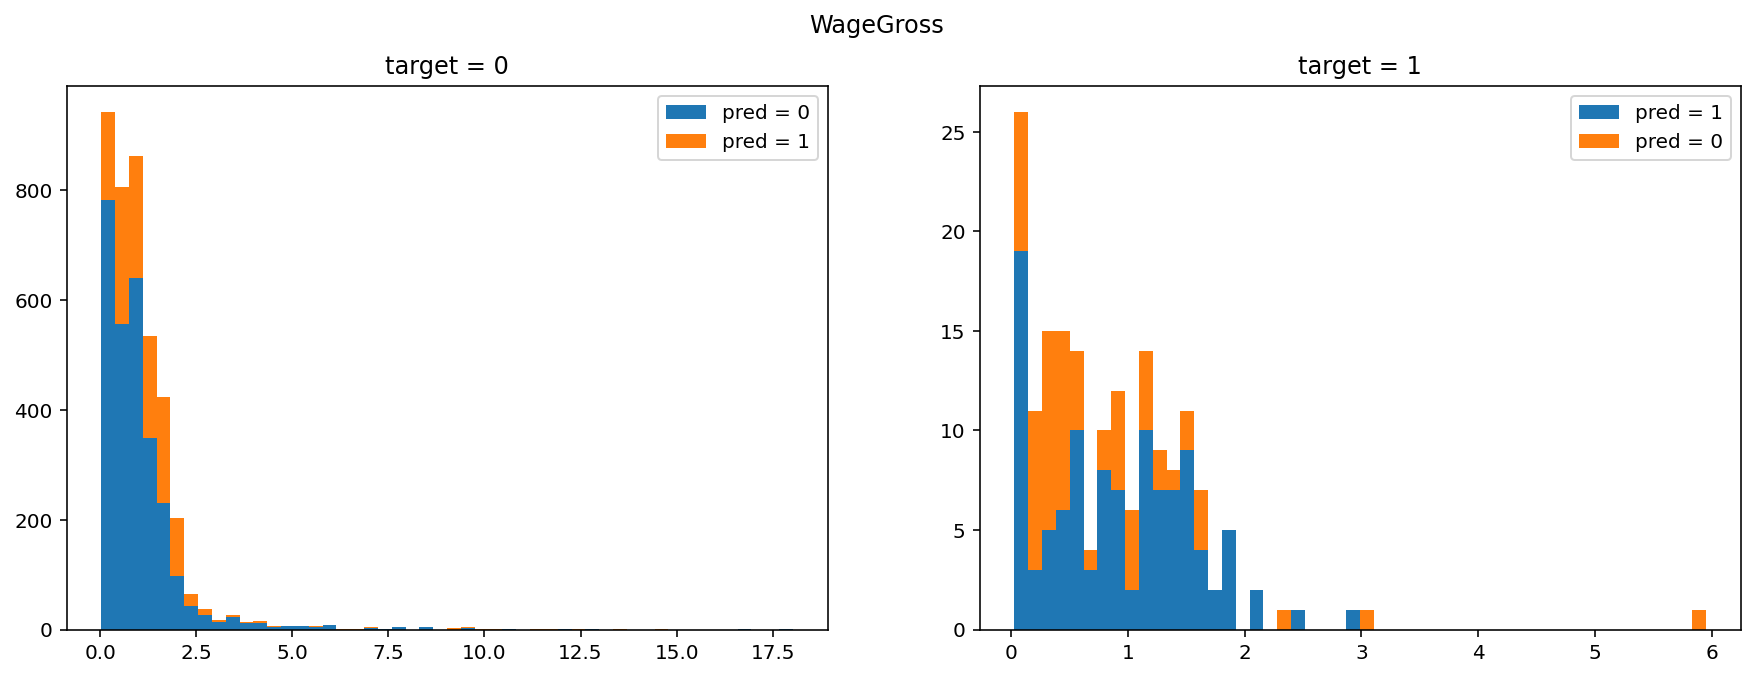

In [0]:
plot_misclass_hist(val_with_pred, 'WageGross', bins=50)

**'SBUID'** - по найпоширенішим (250-350) локаціям не можна робить висновки, однак локації 1-120 є фактором втримання. 

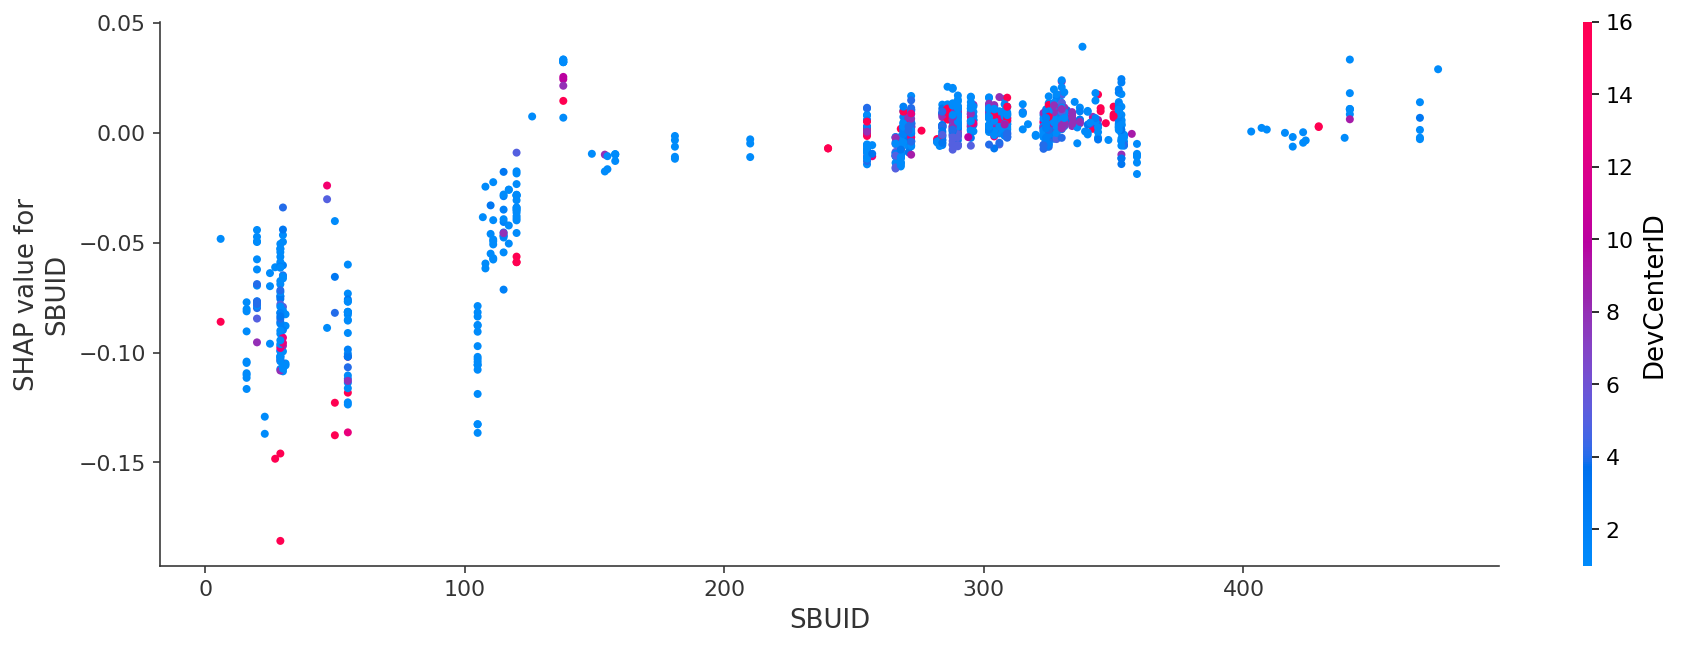

In [0]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
shap.dependence_plot('SBUID', 
                     pd.DataFrame(shap_values[1]).sample(SAMPLE_SIZE, random_state=1).values,
                     X_train.sample(SAMPLE_SIZE, random_state=1), 
                     interaction_index="DevCenterID", 
                     ax=ax1,
                     )

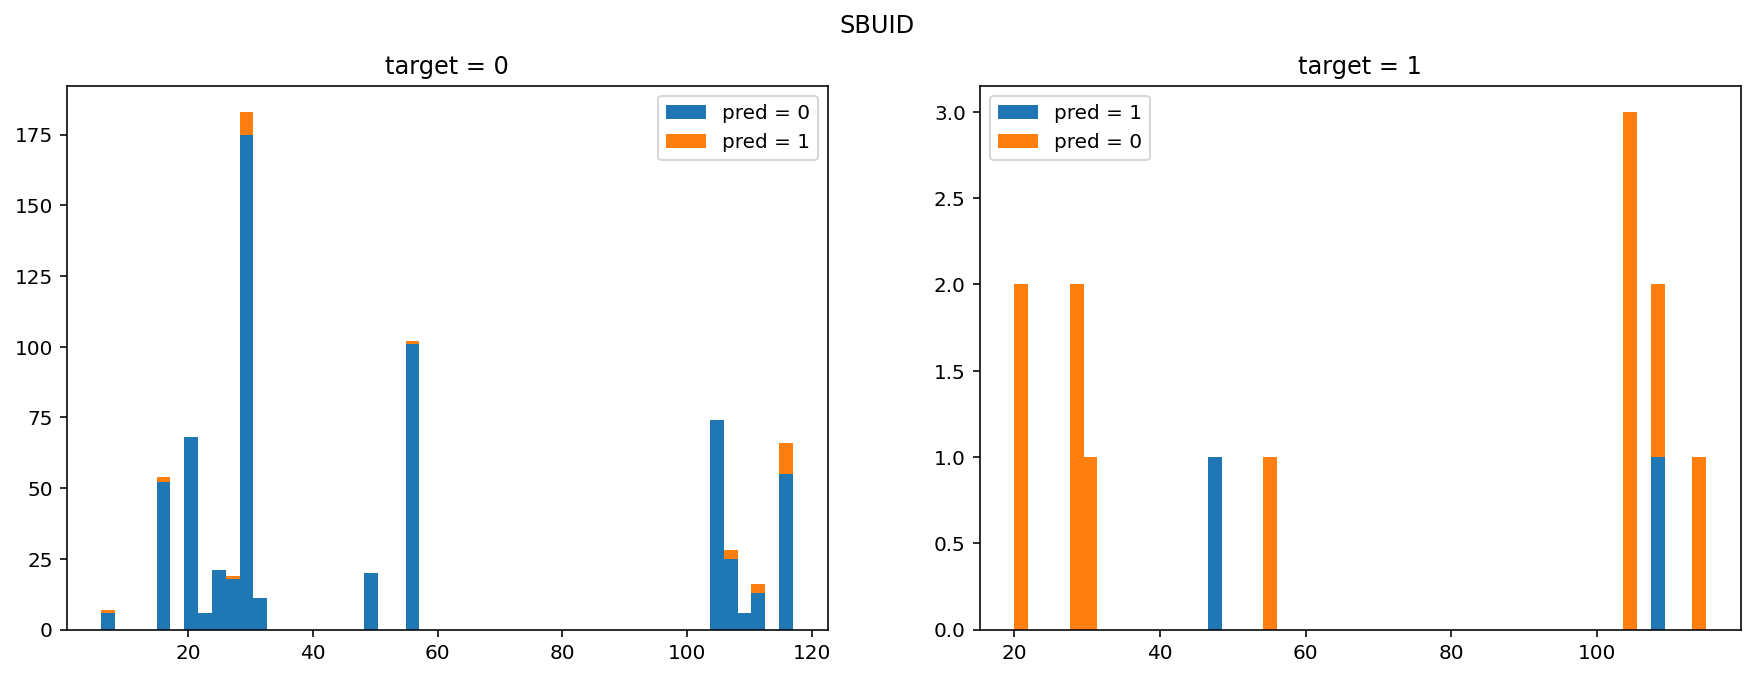

In [0]:
plot_misclass_hist(val_with_pred[val_with_pred['SBUID'] < 120], 'SBUID', bins=50)

**'HourMobileReserve'** - значення вище 25 - фактор уходу.

In [0]:
val['HourMobileReserve'].agg(['mean', 'std'])

mean     2.217836
std     17.320607
Name: HourMobileReserve, dtype: float64

In [0]:
print('samples with HourMobileReserve = 0: ', val[val['HourMobileReserve'] == 0].shape[0])
print('samples with HourMobileReserve > 0: ', val[val['HourMobileReserve'] > 0].shape[0])

samples with HourMobileReserve = 0:  4117
samples with HourMobileReserve > 0:  88


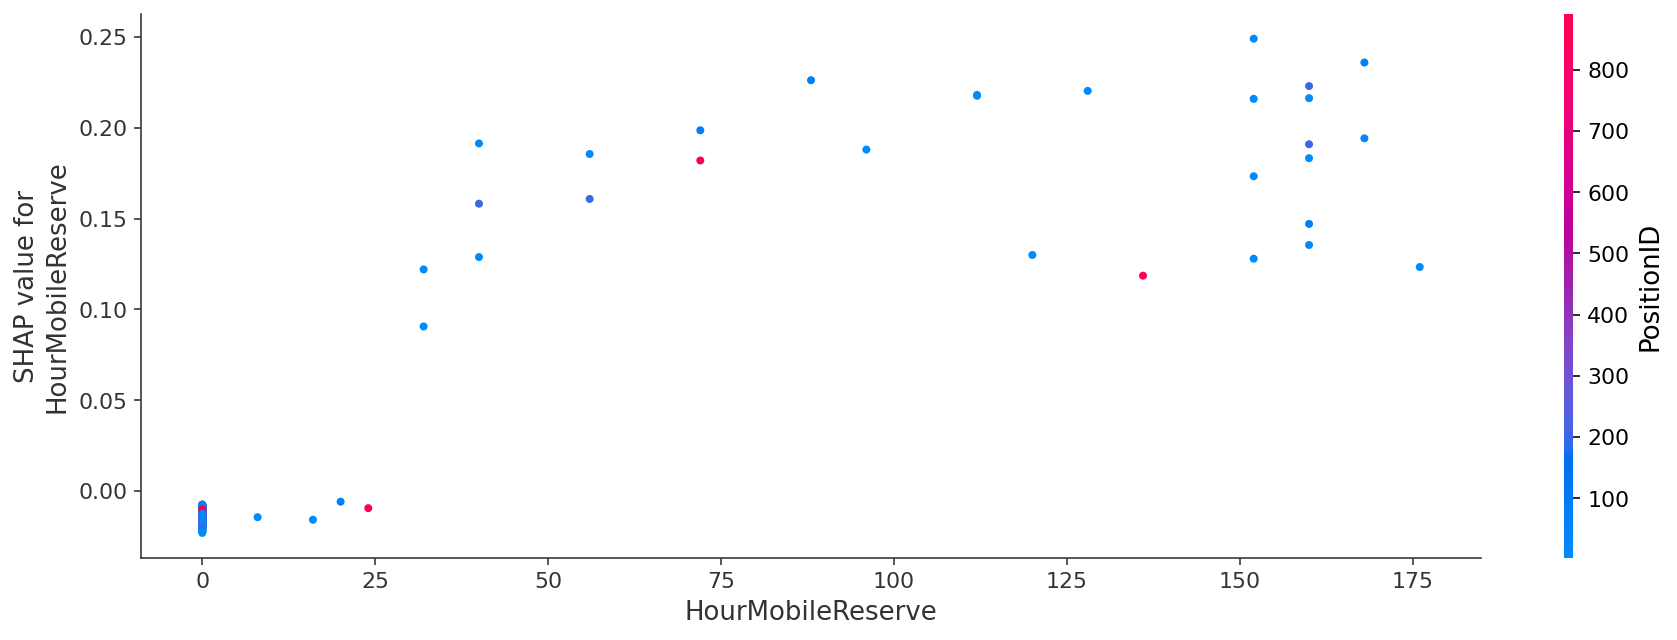

In [0]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
shap.dependence_plot('HourMobileReserve', 
                     pd.DataFrame(shap_values[1]).sample(SAMPLE_SIZE, random_state=1).values,
                     X_train.sample(SAMPLE_SIZE, random_state=1), 
                     interaction_index="PositionID", 
                     ax=ax1,
                     )

Хоч модель і позначала "в зоні ризику" кілька десятків семплів, які насправді не були в зоні ризику, однак для тих кількох семплів з ризиком HourMobileReserve виявився потужним фактором - можна брати наявність HourMobileReserve за alert

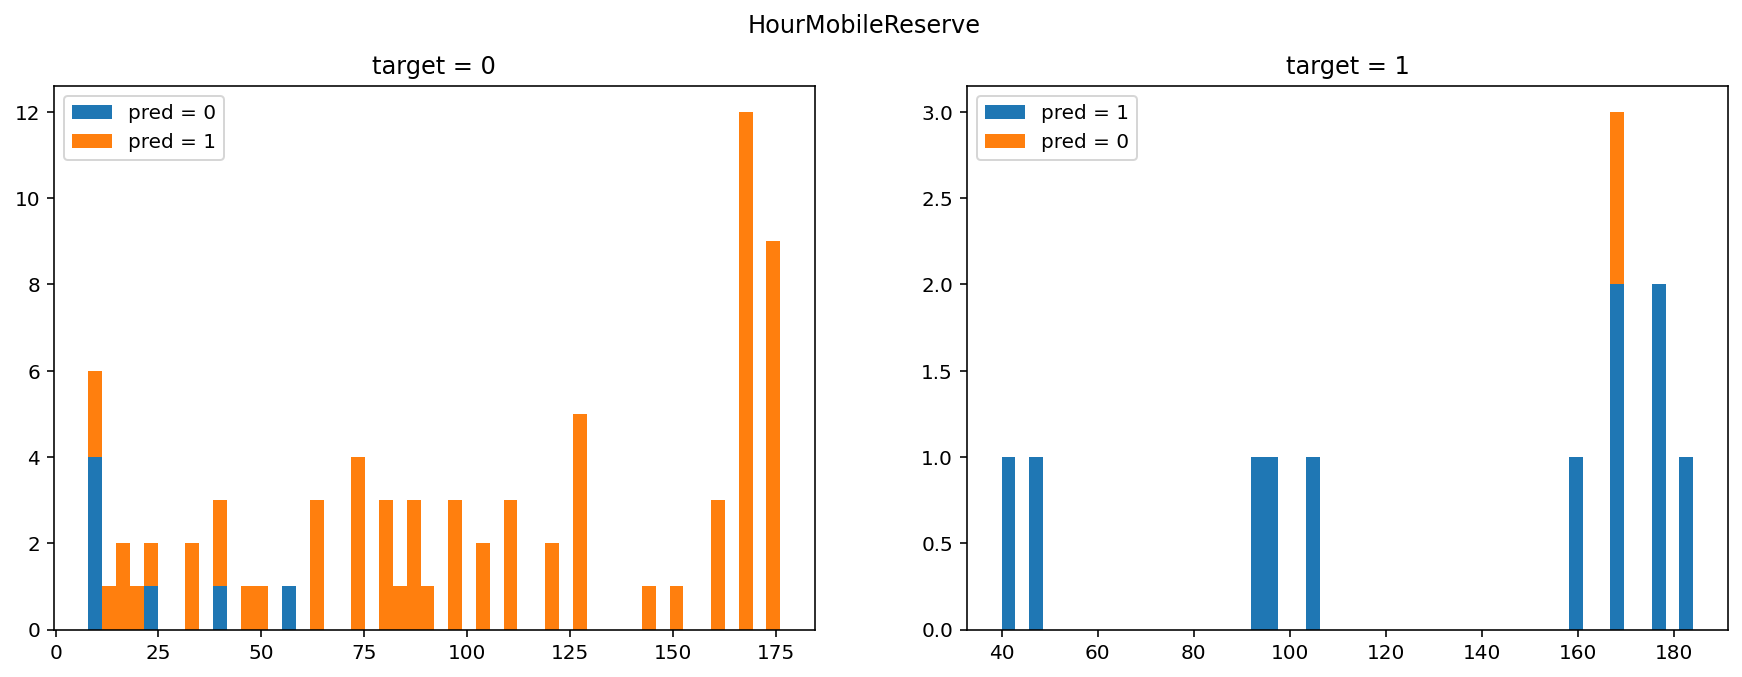

In [0]:
# almost all values are "0", so omit them
plot_misclass_hist(val_with_pred[val_with_pred['HourMobileReserve'] > 0], 'HourMobileReserve', bins=50)

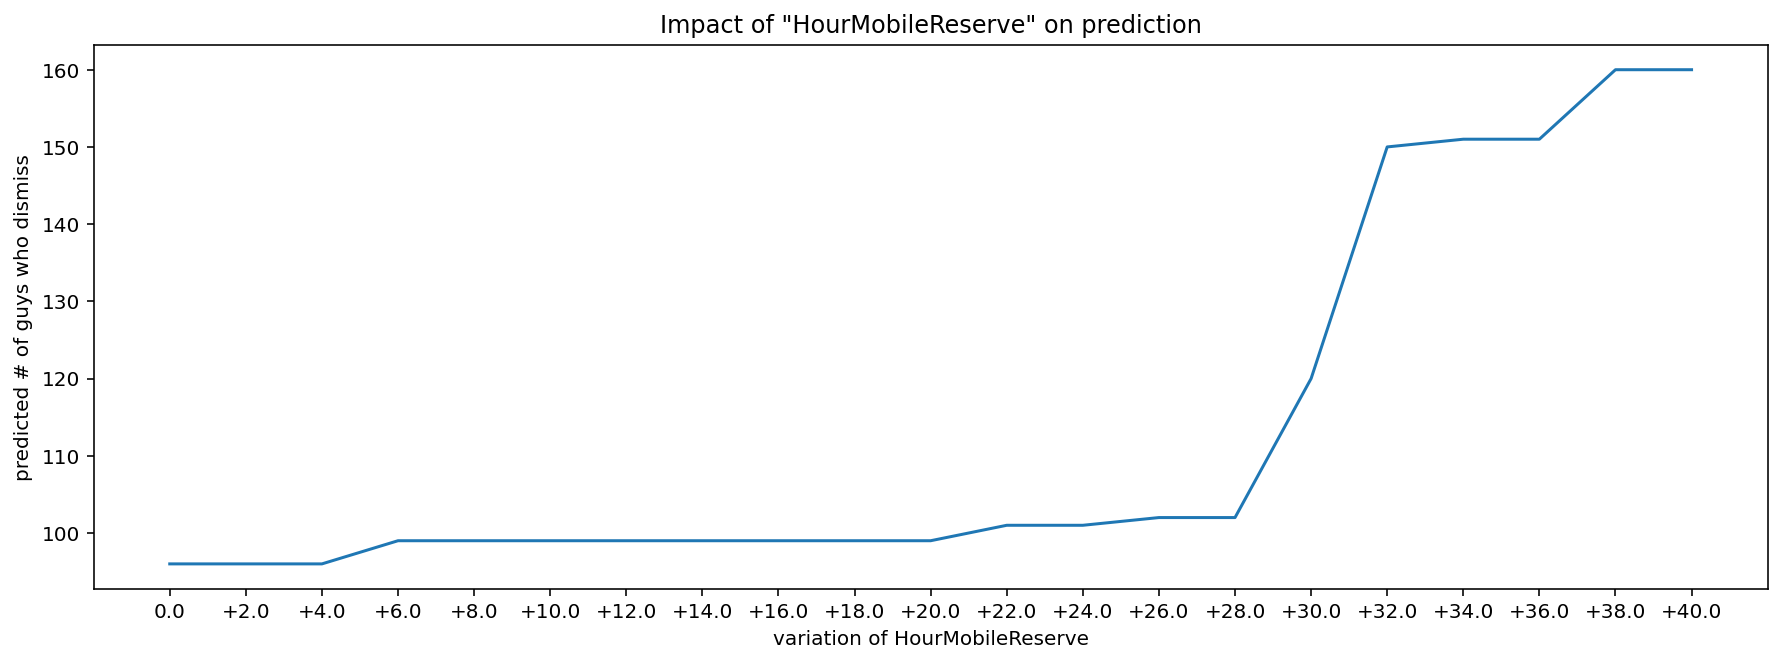

In [0]:
plt.figure(figsize=(15,5))
variate_factor('HourMobileReserve', model, val, np.linspace(0, 40, 21))

**PositionID** - позиції вище 207 - утримуючий фактор

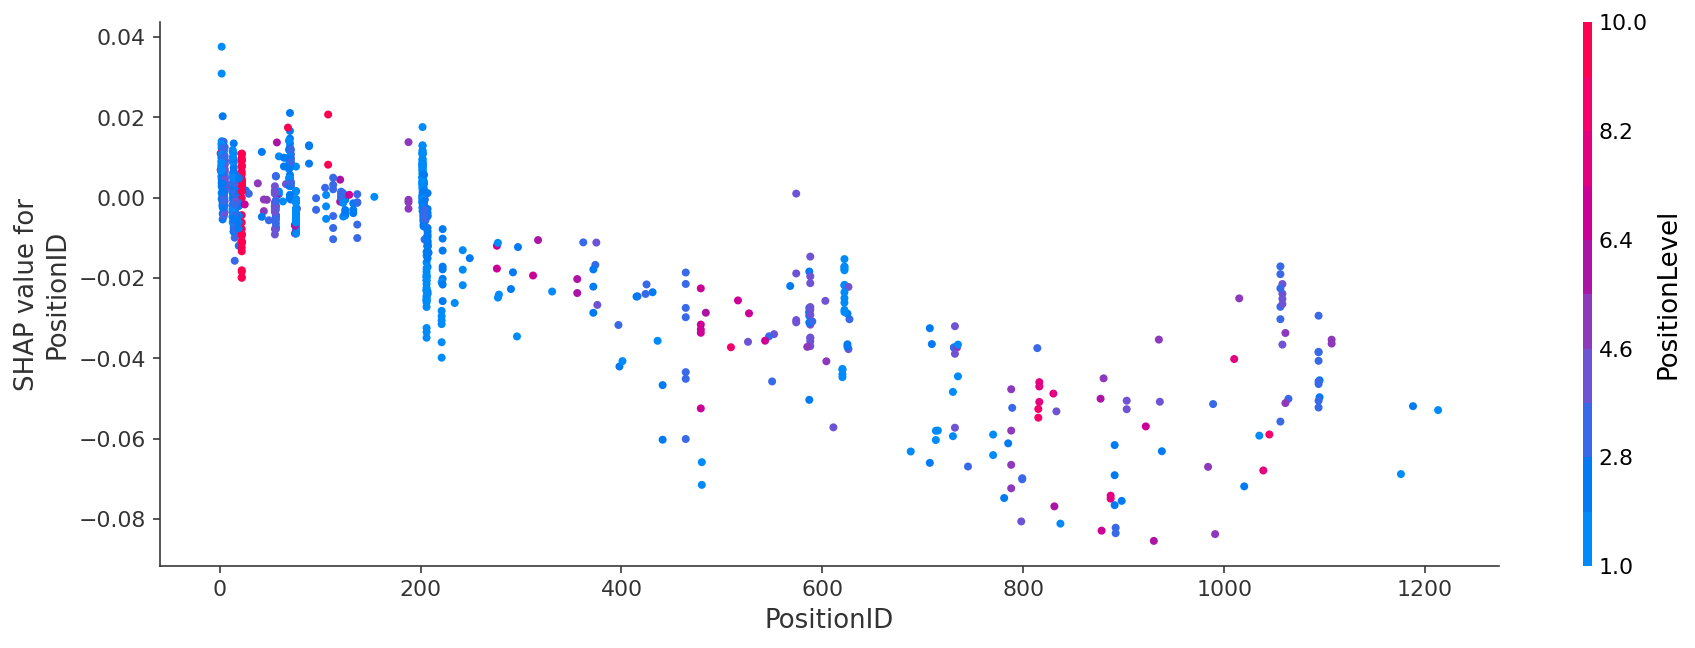

In [0]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
shap.dependence_plot('PositionID', 
                     pd.DataFrame(shap_values[1]).sample(SAMPLE_SIZE, random_state=1).values,
                     X_train.sample(SAMPLE_SIZE, random_state=1), 
                     interaction_index="PositionLevel", 
                     ax=ax1,
                     )

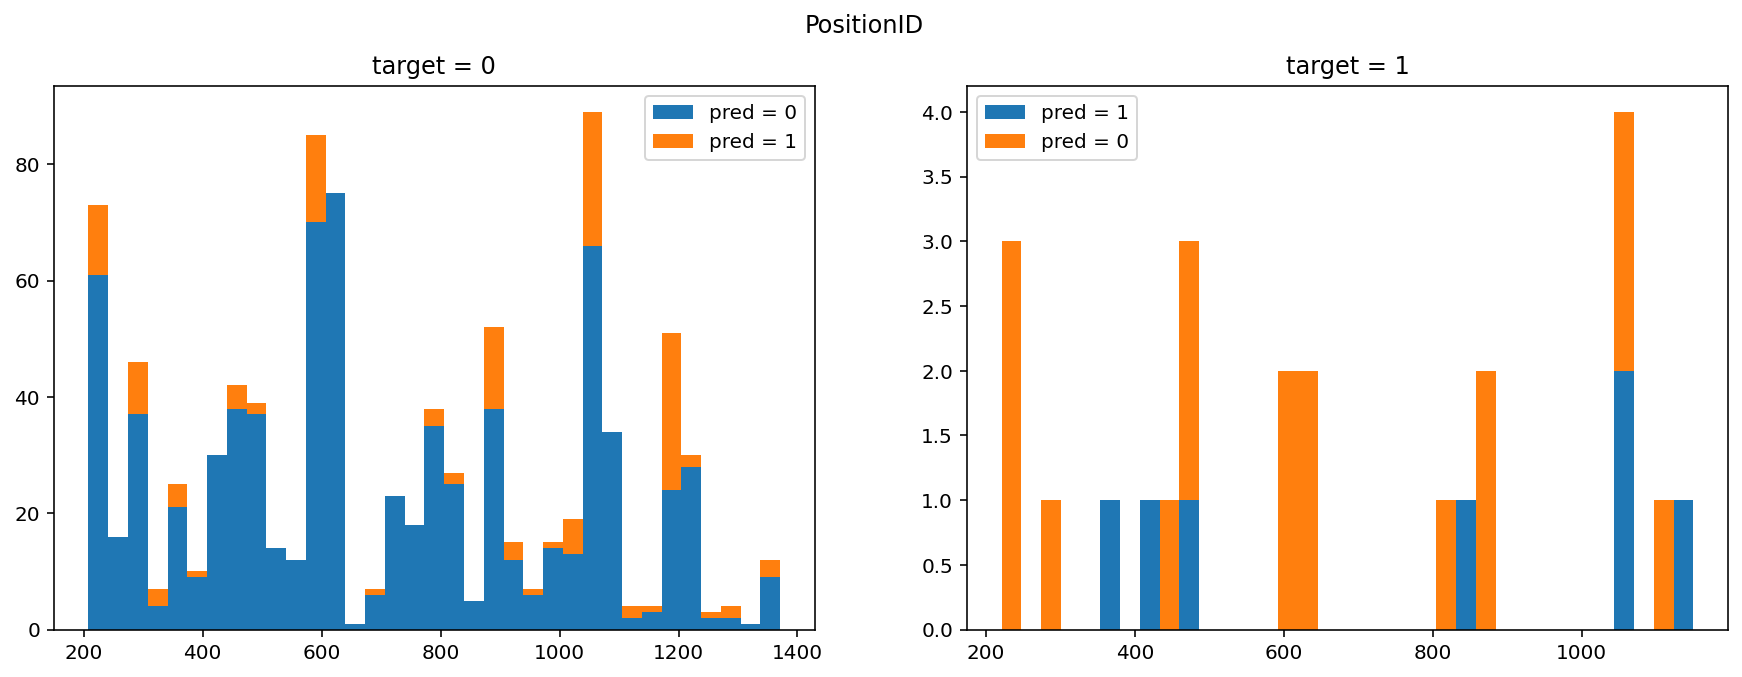

In [0]:
plot_misclass_hist(val_with_pred[val_with_pred['PositionID'] > 207], 'PositionID')

**MonthOnSalary** - приблизно 10 місяців є точкою, після якої збільшується к-сть уходів.

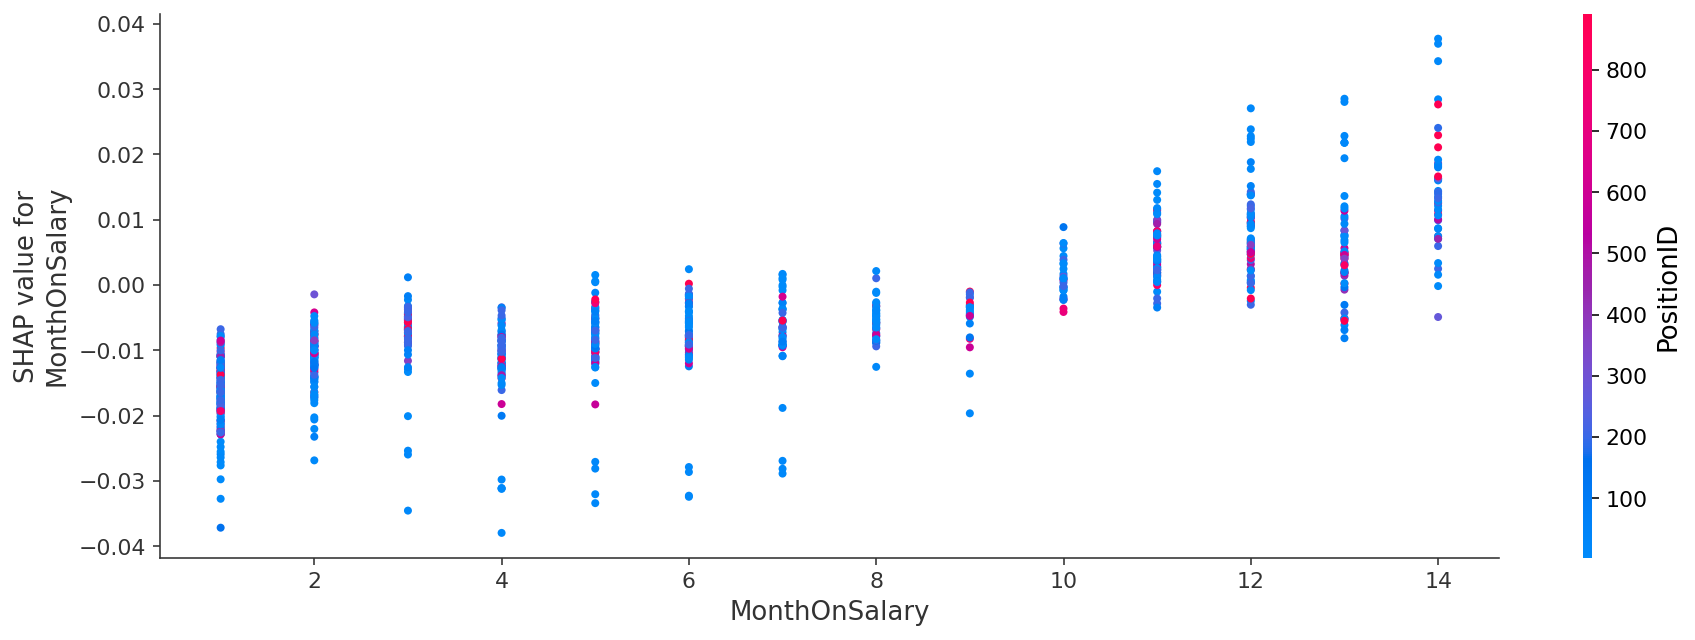

In [0]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
shap.dependence_plot('MonthOnSalary', 
                     pd.DataFrame(shap_values[1]).sample(SAMPLE_SIZE, random_state=1).values,
                     X_train.sample(SAMPLE_SIZE, random_state=1), 
                     interaction_index="PositionID", 
                     ax=ax1,
                     )

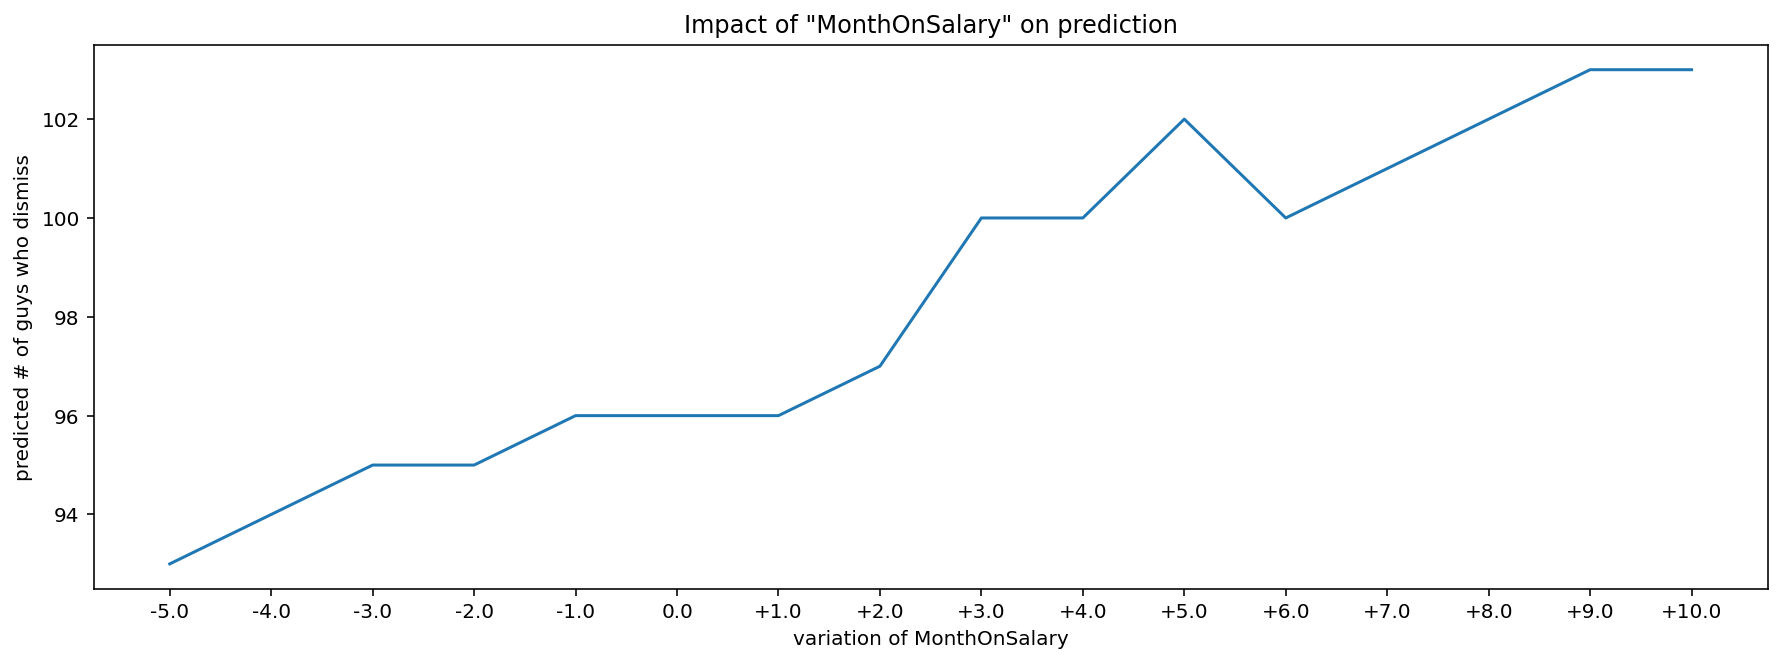

In [0]:
plt.figure(figsize=(15,5))
variate_factor('MonthOnSalary', model, val, np.linspace(-5, 10, 16))

**BonusOneTime** - будь-який мінімальний бонус збільшує шанси втримання.

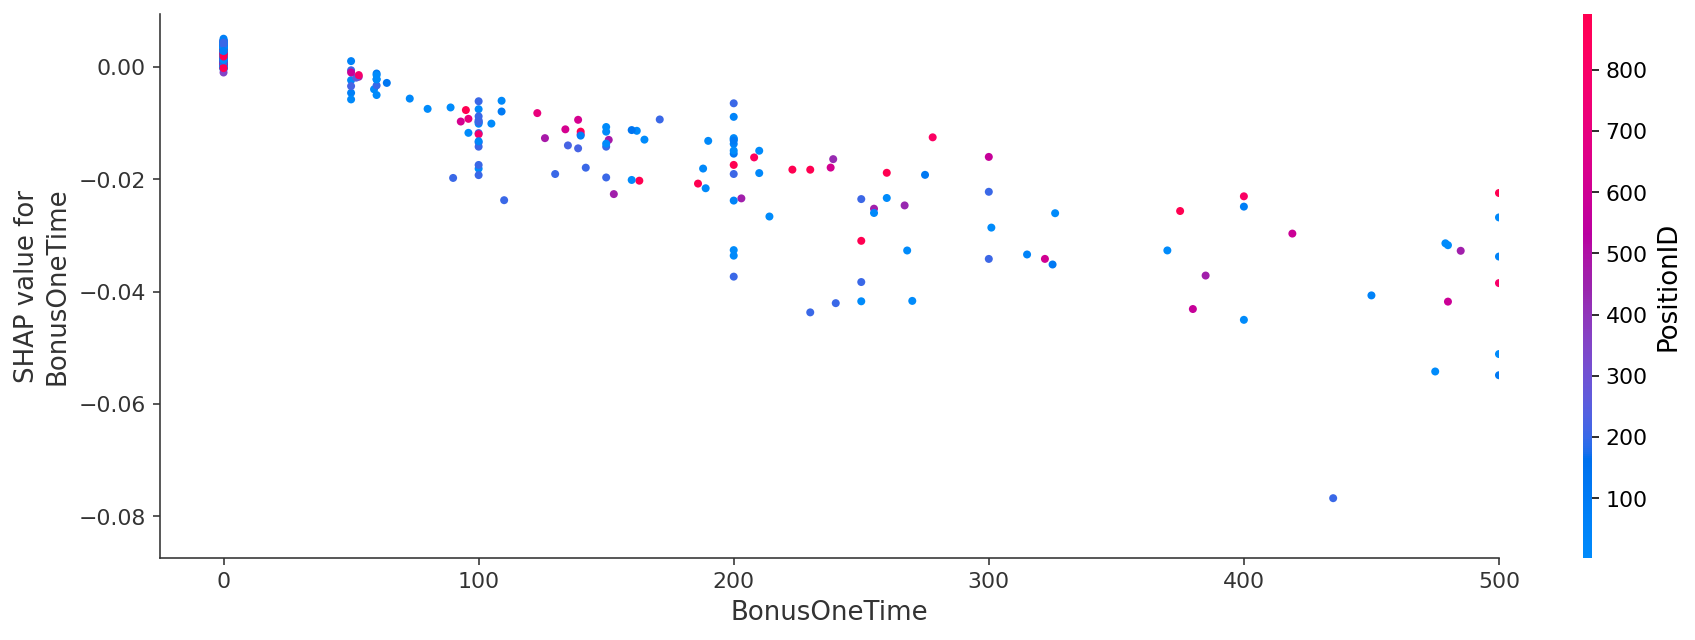

In [0]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
shap.dependence_plot('BonusOneTime', 
                     pd.DataFrame(shap_values[1]).sample(SAMPLE_SIZE, random_state=1).values,
                     X_train.sample(SAMPLE_SIZE, random_state=1), 
                     interaction_index="PositionID", 
                     ax=ax1,
                     xmax=500)

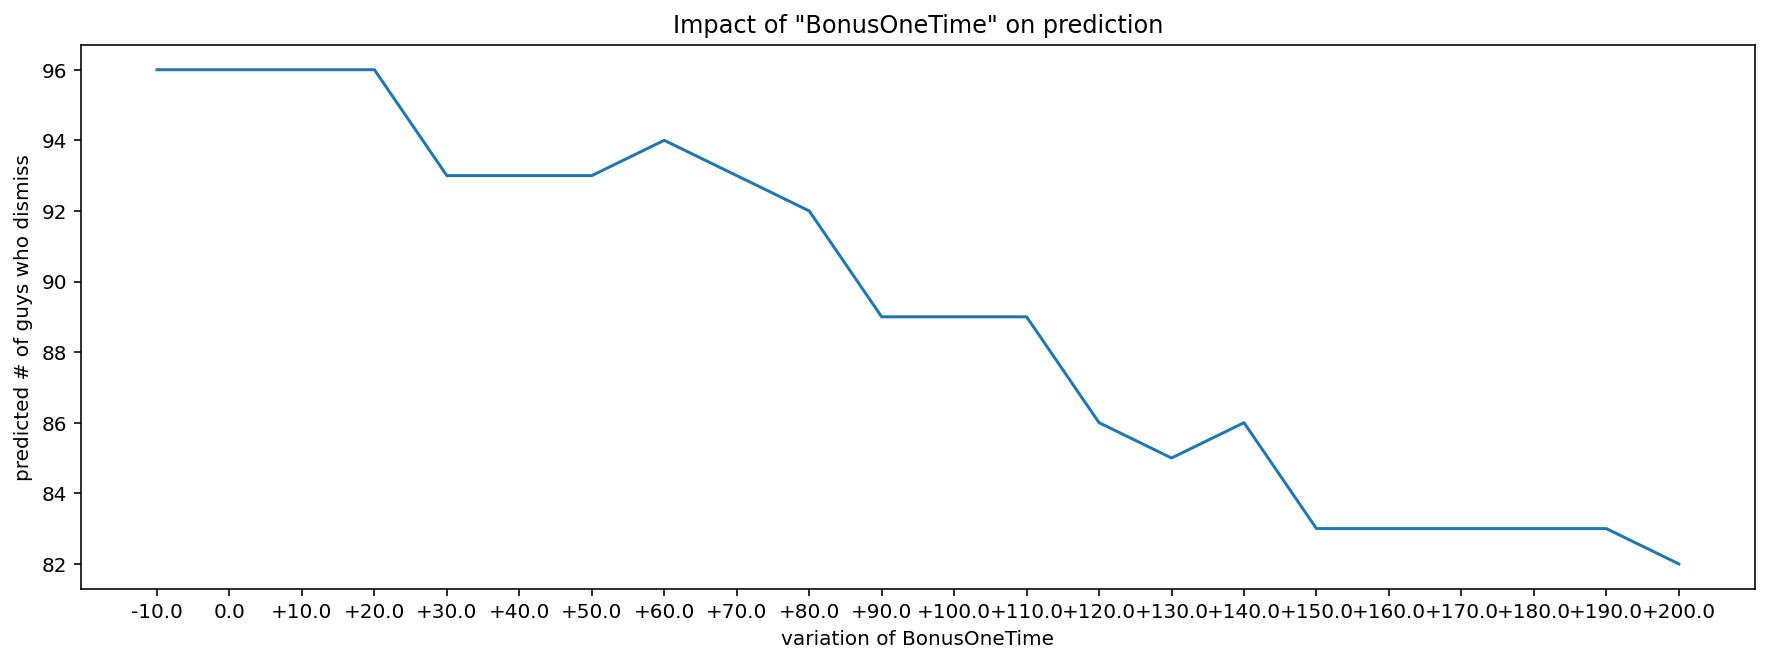

In [0]:
plt.figure(figsize=(15,5))
variate_factor('BonusOneTime', model, val, np.linspace(-10, 200, 22))

## What-if

Створимо середньостатистичного робітника і будемо варіювати параметри для нього

In [0]:
sample = {
    'DevCenterID': 1,
    'SBUID': 255,
    'PositionID': 200,
    'PositionLevel': 3,
    'LanguageLevelID': 12,
    'IsTrainee': 0,
    'CustomerID': 110,
    'ProjectID': 900,
    'IsInternalProject': 0,
    'Utilization': 1, 
    'HourVacation': 0,
    'HourMobileReserve': 0,
    'HourLockedReserve': 0,
    'OnSite': 0,
    'CompetenceGroupID': 17,
    'FunctionalOfficeID': 1,
    'PaymentTypeId': 18,
    'BonusOneTime': 0,
    'APM': 26,
    'WageGross': 1,
    'MonthOnPosition': 9,
    'MonthOnSalary': 6,
    'experience_months': 33
}
sample_df = pd.DataFrame([sample])
sample_df.T

,0
DevCenterID,1
SBUID,255
PositionID,200
PositionLevel,3
LanguageLevelID,12
IsTrainee,0
CustomerID,110
ProjectID,900
IsInternalProject,0
Utilization,1


In [0]:
def variate_single_sample_factor(factor, model, sample, variation_range, threshold=0.4):
    variation_values = []
    prediction_probas = []
    
    for value in variation_range:
        sample_copy = sample.copy()
        sample_copy[factor] += value
        
        prediction_proba = model.predict_proba(sample_copy)[:, 1][0]
        
        variation_values.append(str(sample_copy[factor].round(2)[0]))
        prediction_probas.append(prediction_proba)
        
    plt.figure(figsize=(15,5))
    plt.axhline(y=threshold, color='r', linestyle='-')
    plt.plot(variation_values, prediction_probas)
    plt.title('Impact of "'+factor+'" on single-sample prediction')
    plt.xlabel('variation of ' + factor)
    plt.ylabel('prediction proba')
    plt.show()

**experience_months** - при значеннях < 27 передбачення наявності ризику.

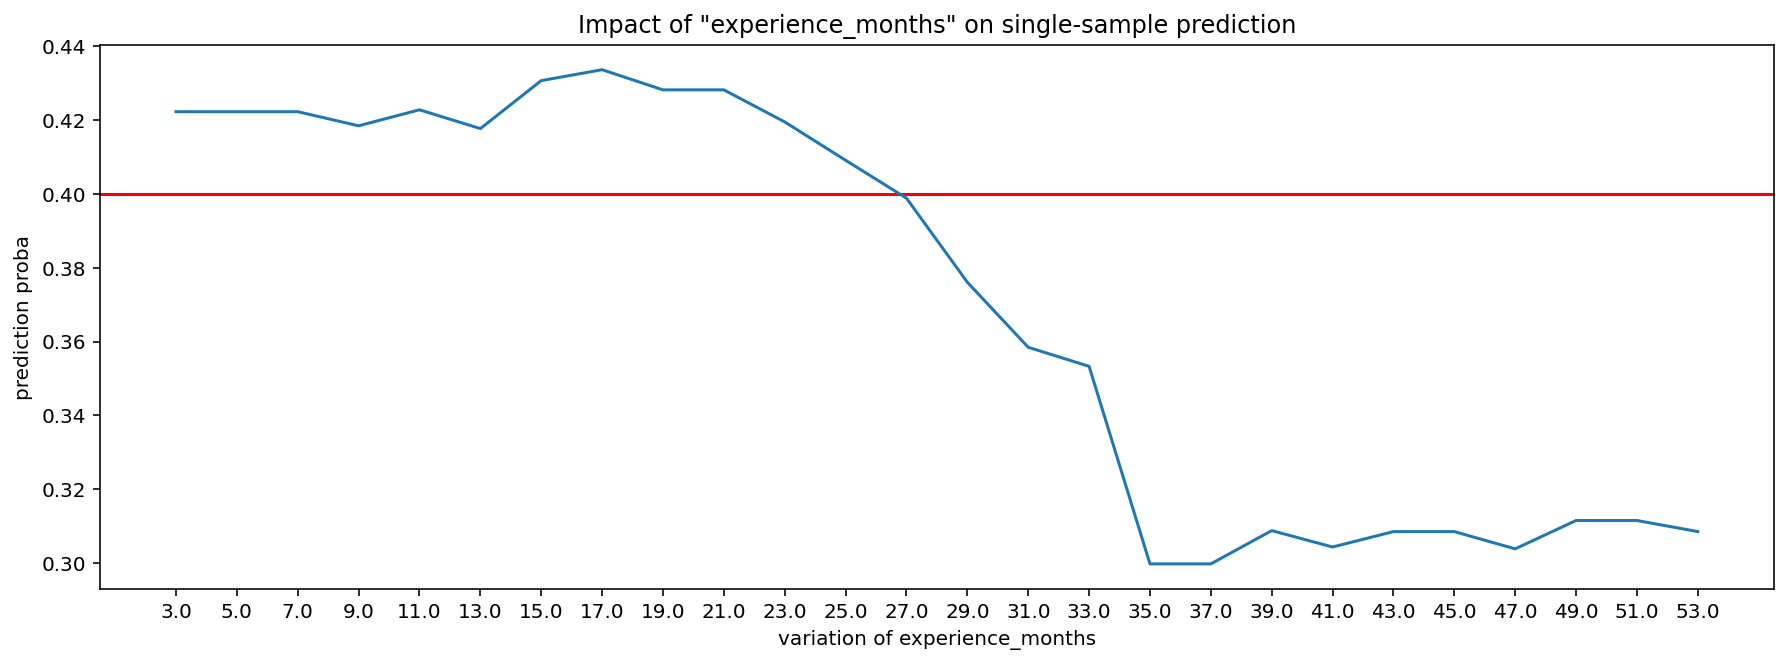

In [0]:
variate_single_sample_factor('experience_months', model, sample_df, np.linspace(-30, 20, 26))

**DevCenterID** - при значеннях > 7 передбачення наявності ризику.

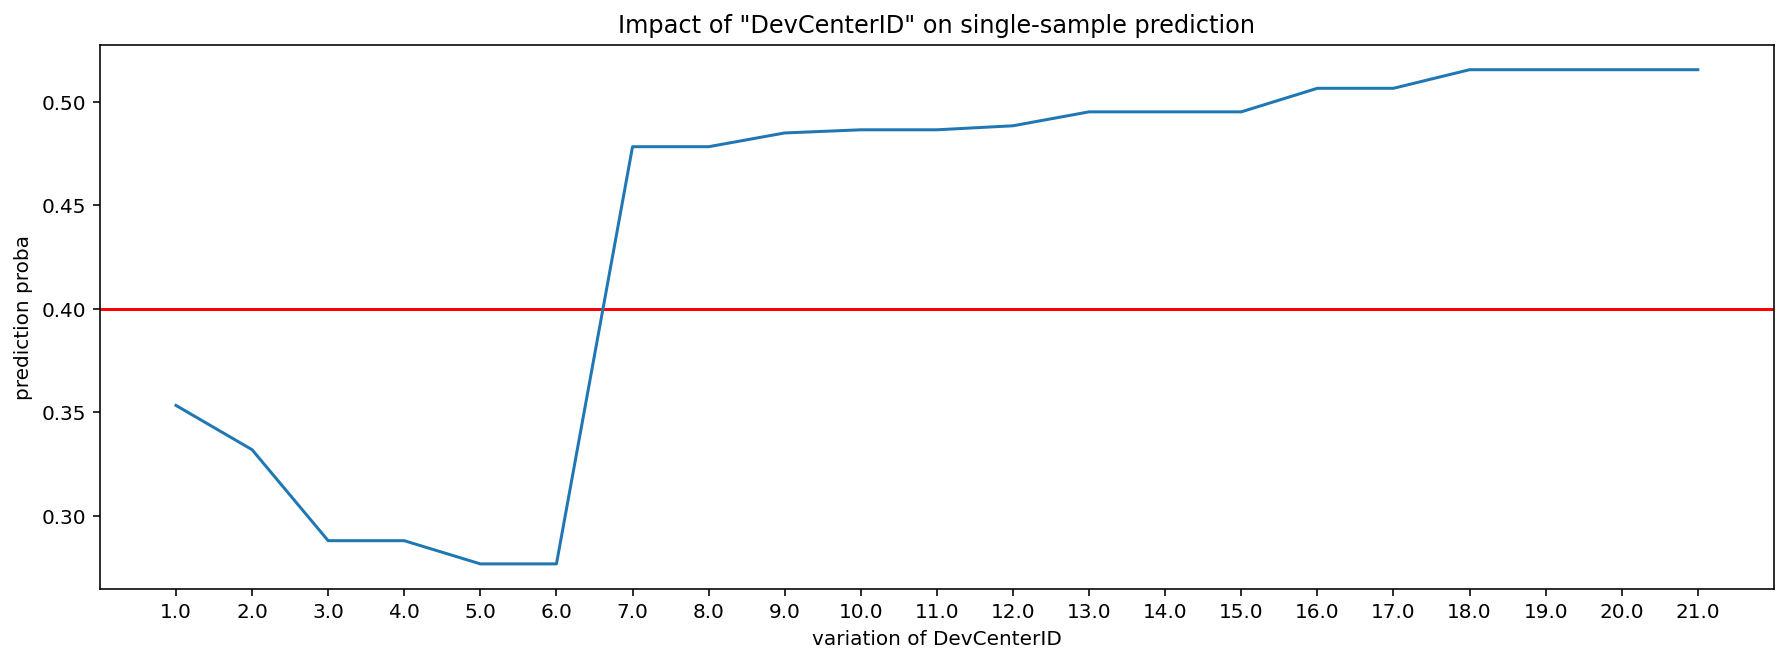

In [0]:
variate_single_sample_factor('DevCenterID', model, sample_df, np.linspace(0, 20, 21))

**WageGross** - ризик при значенні < 0.1

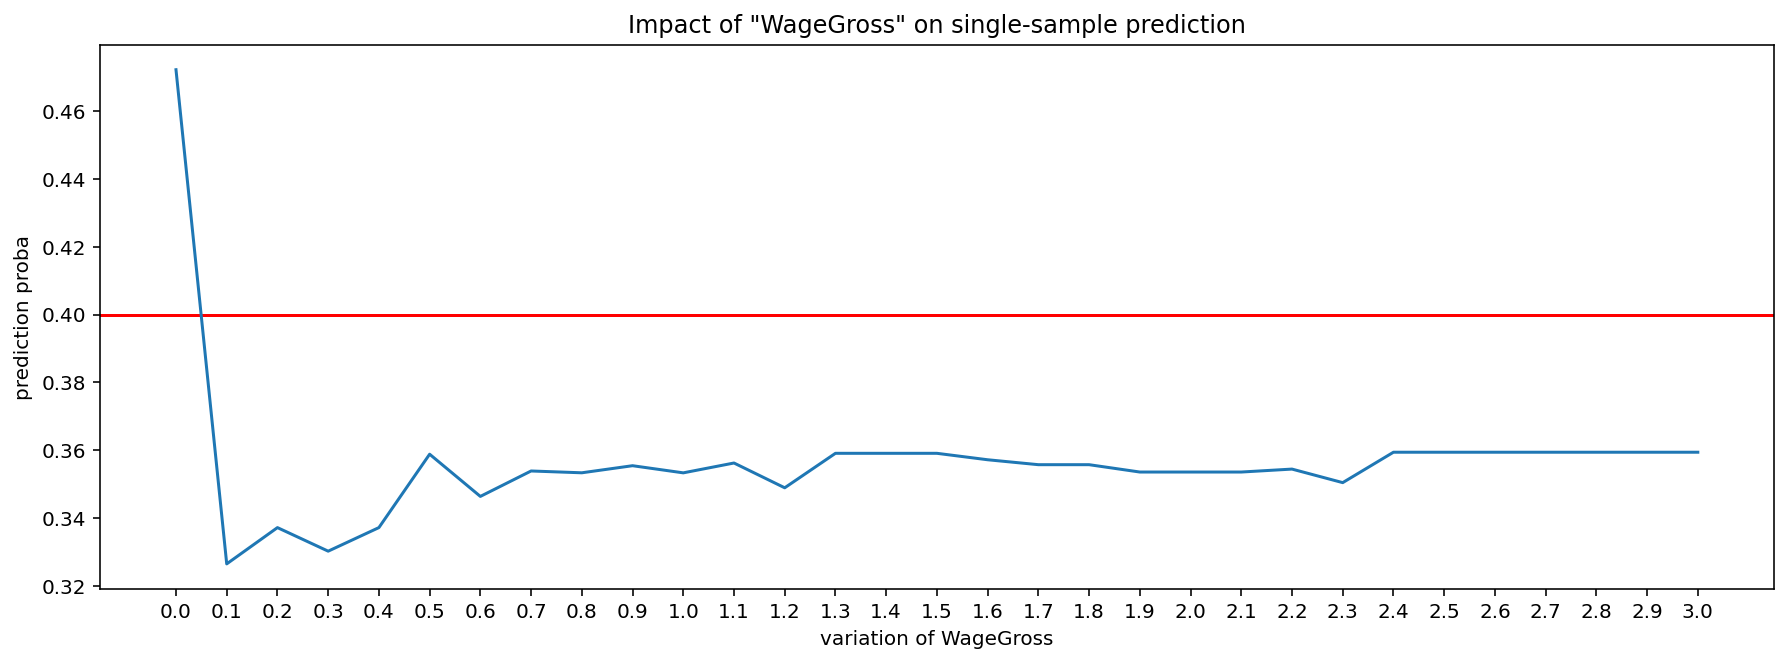

In [0]:
variate_single_sample_factor('WageGross', model, sample_df, np.linspace(-1, 2, 31))

**SBUID** - при поточних інших параметрах, цей не має впливу

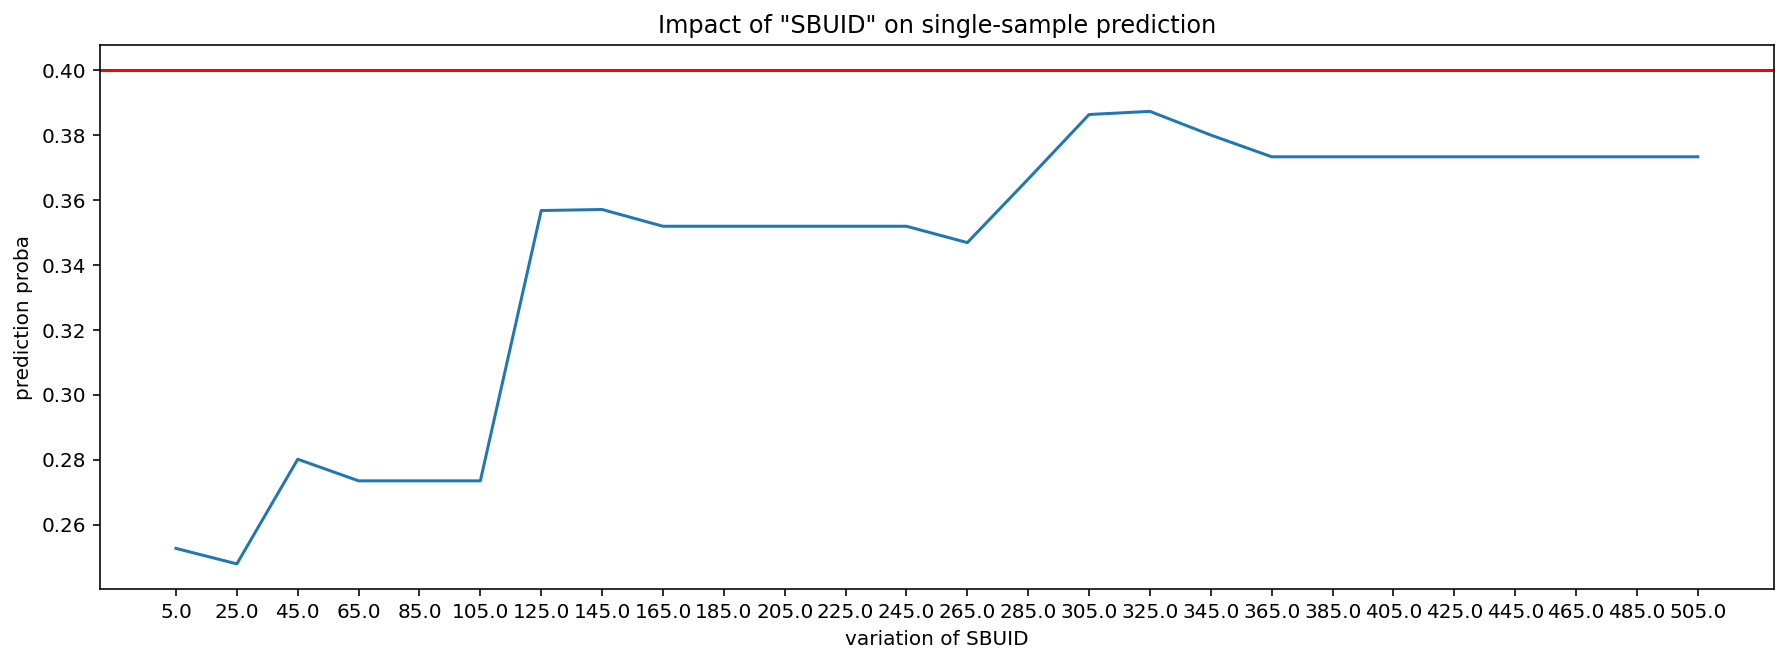

In [0]:
variate_single_sample_factor('SBUID', model, sample_df, np.linspace(-250, 250, 26))

**HourMobileReserve** - ризик при значеннях > 30

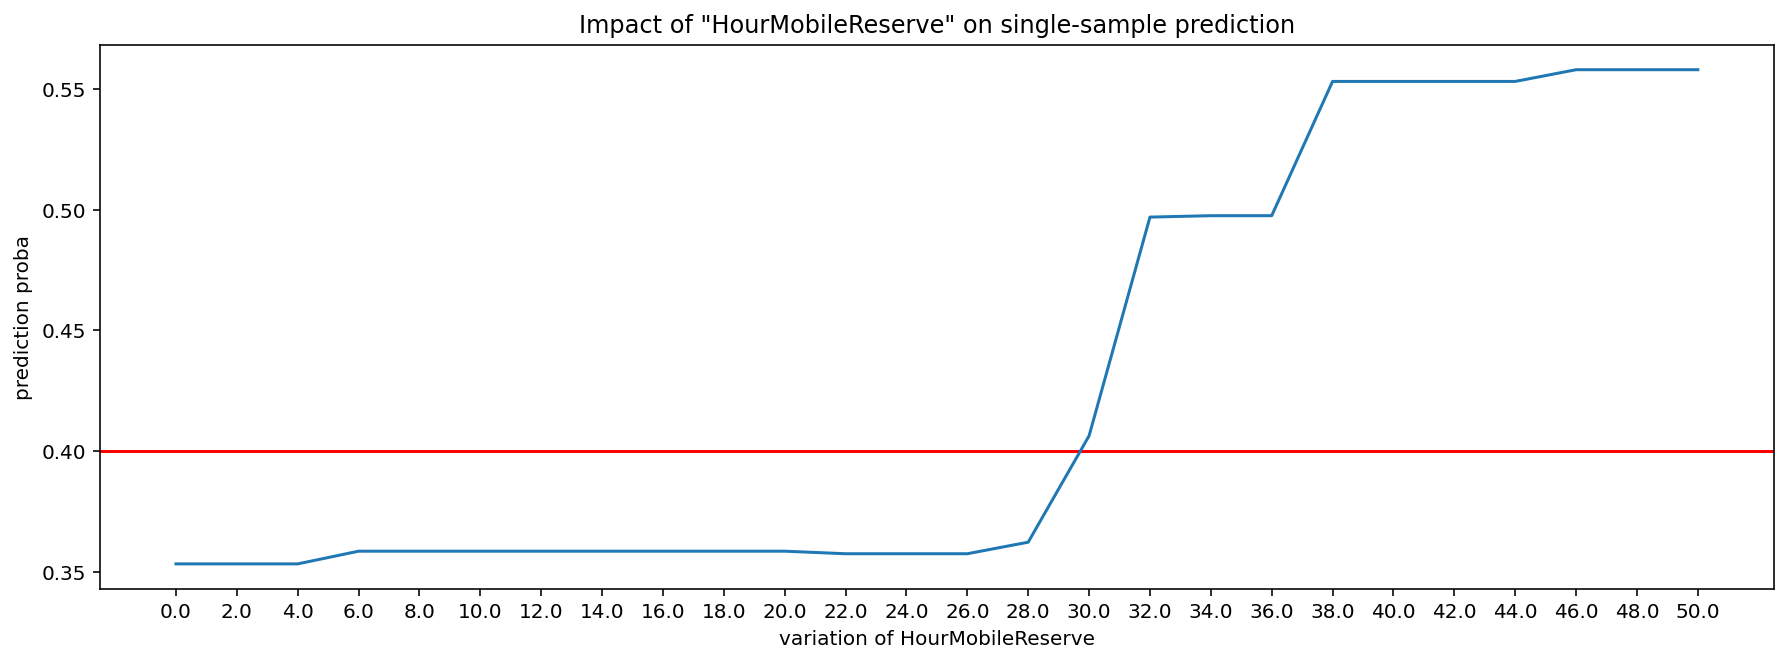

In [0]:
variate_single_sample_factor('HourMobileReserve', model, sample_df, np.linspace(0, 50, 26))

**Всі інші параметри, при поточних значеннях решти, впливу не мають**

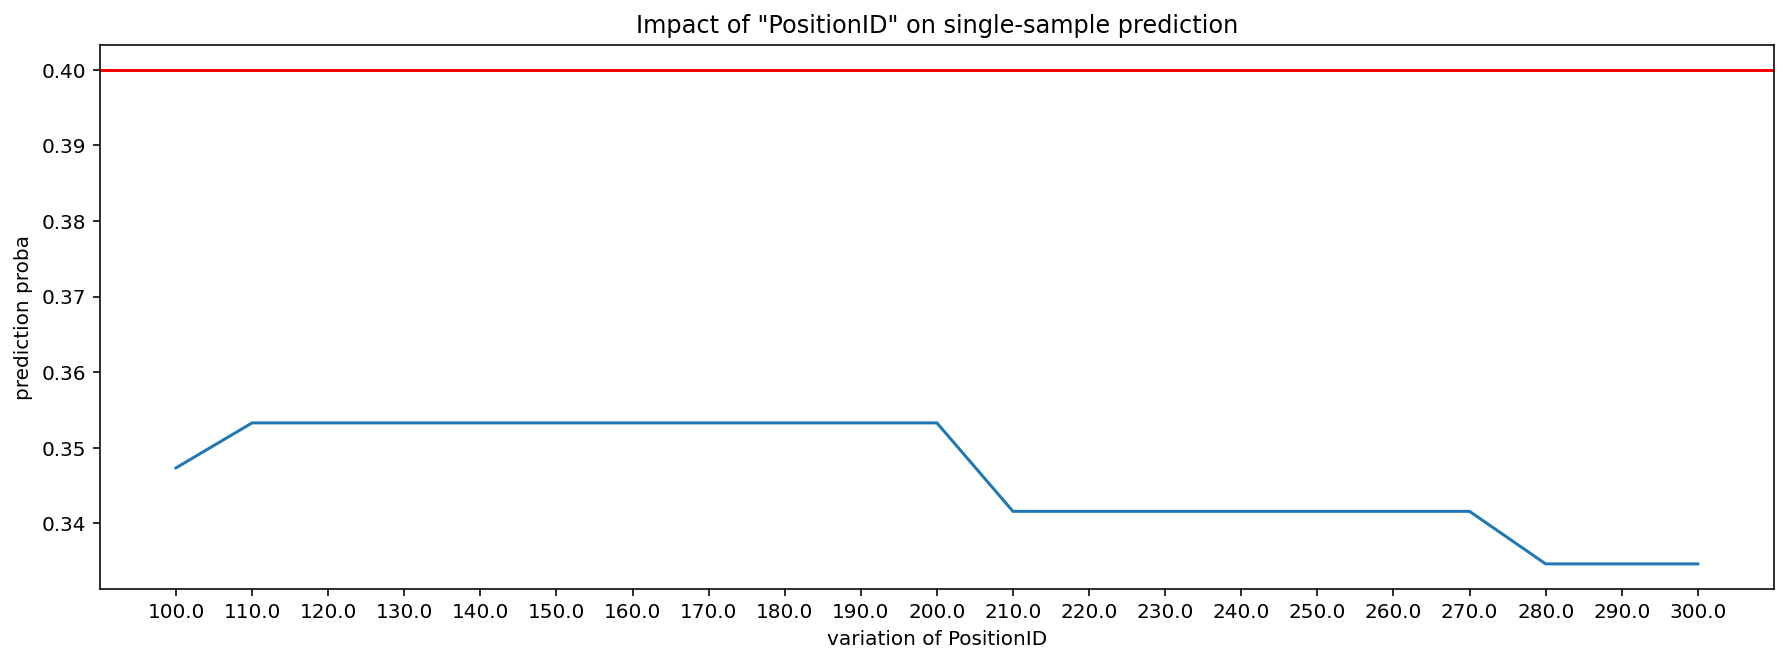

In [0]:
variate_single_sample_factor('PositionID', model, sample_df, np.linspace(-100, 100, 21))

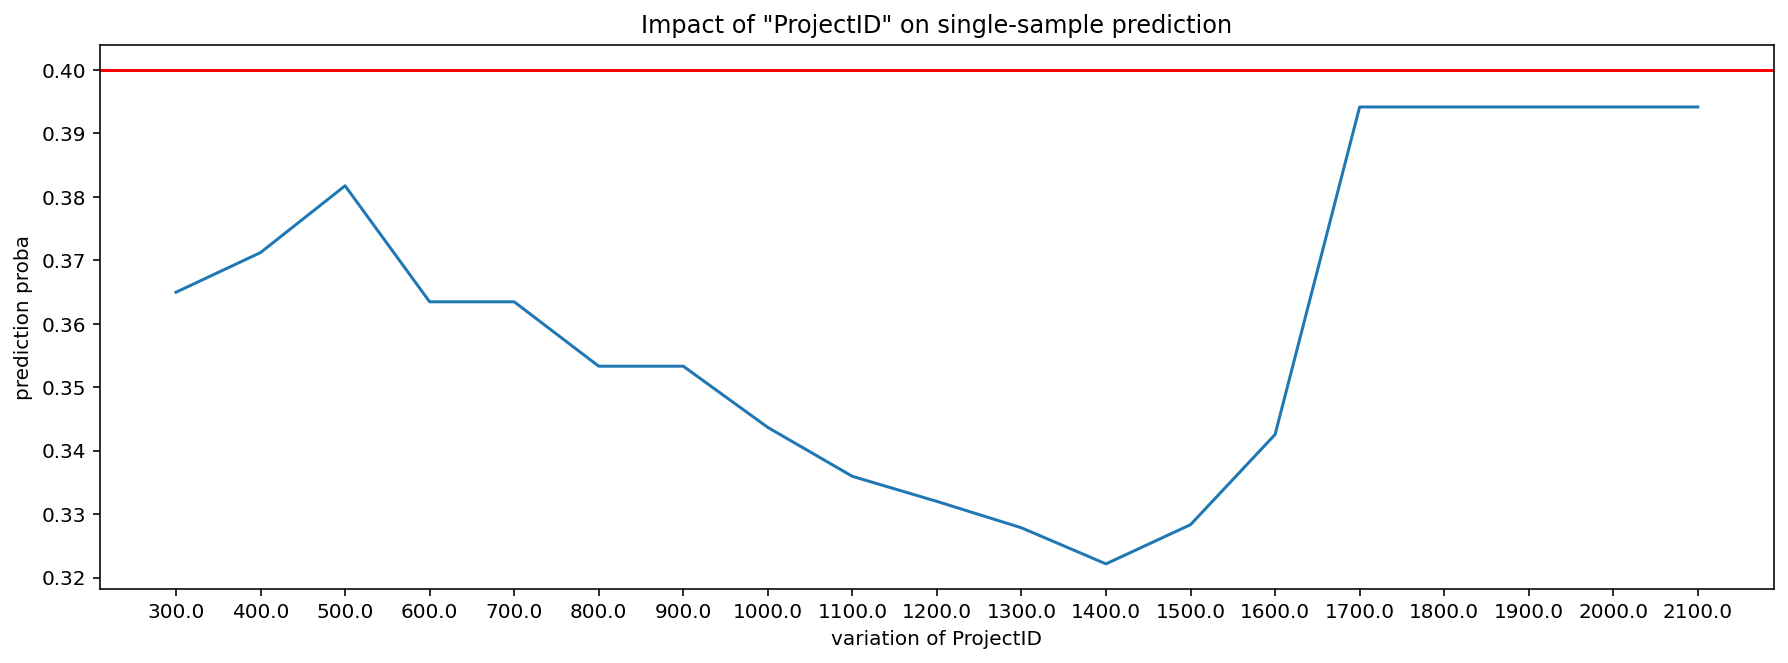

In [0]:
variate_single_sample_factor('ProjectID', model, sample_df, np.linspace(-600, 1200, 19))

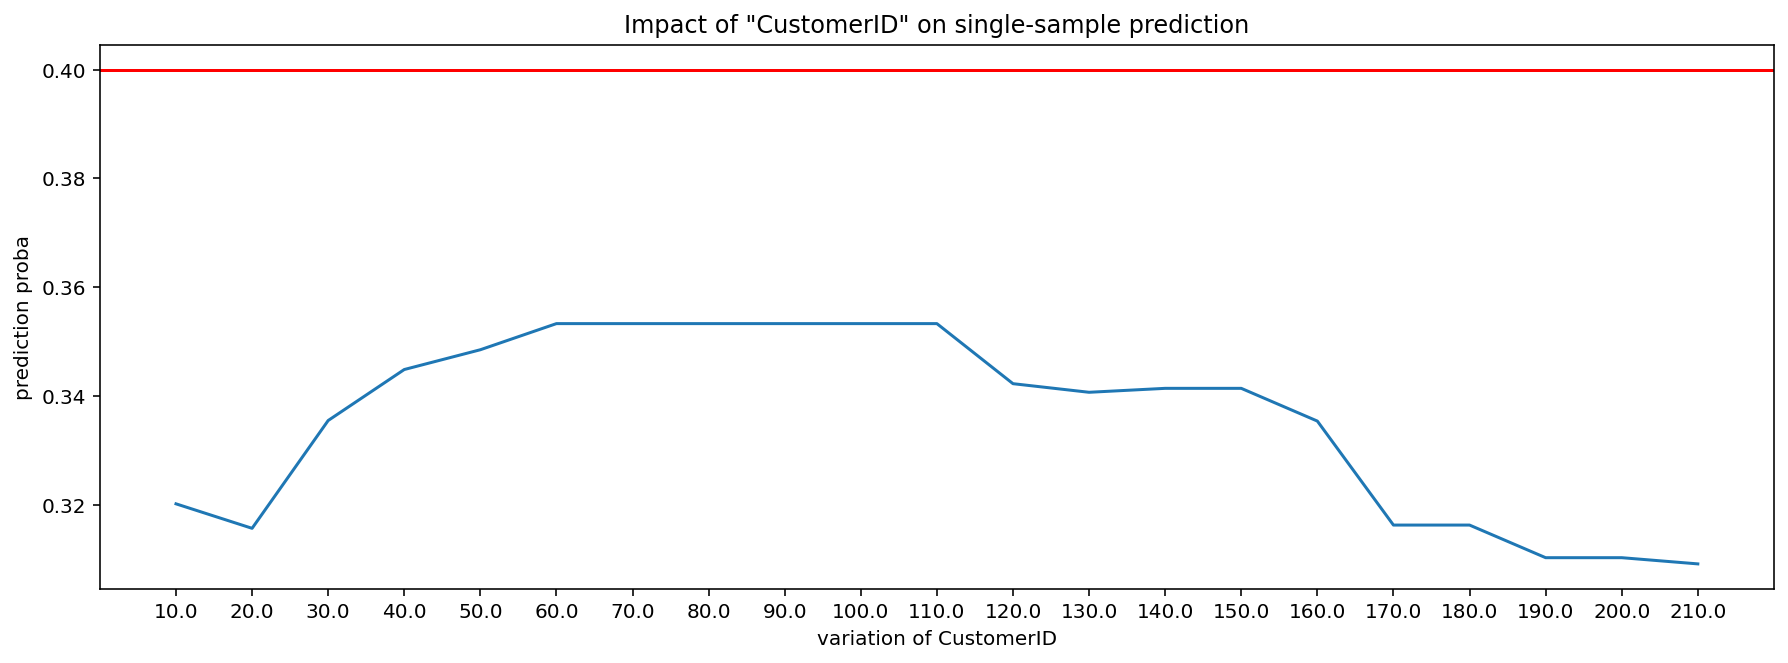

In [0]:
variate_single_sample_factor('CustomerID', model, sample_df, np.linspace(-100, 100, 21))

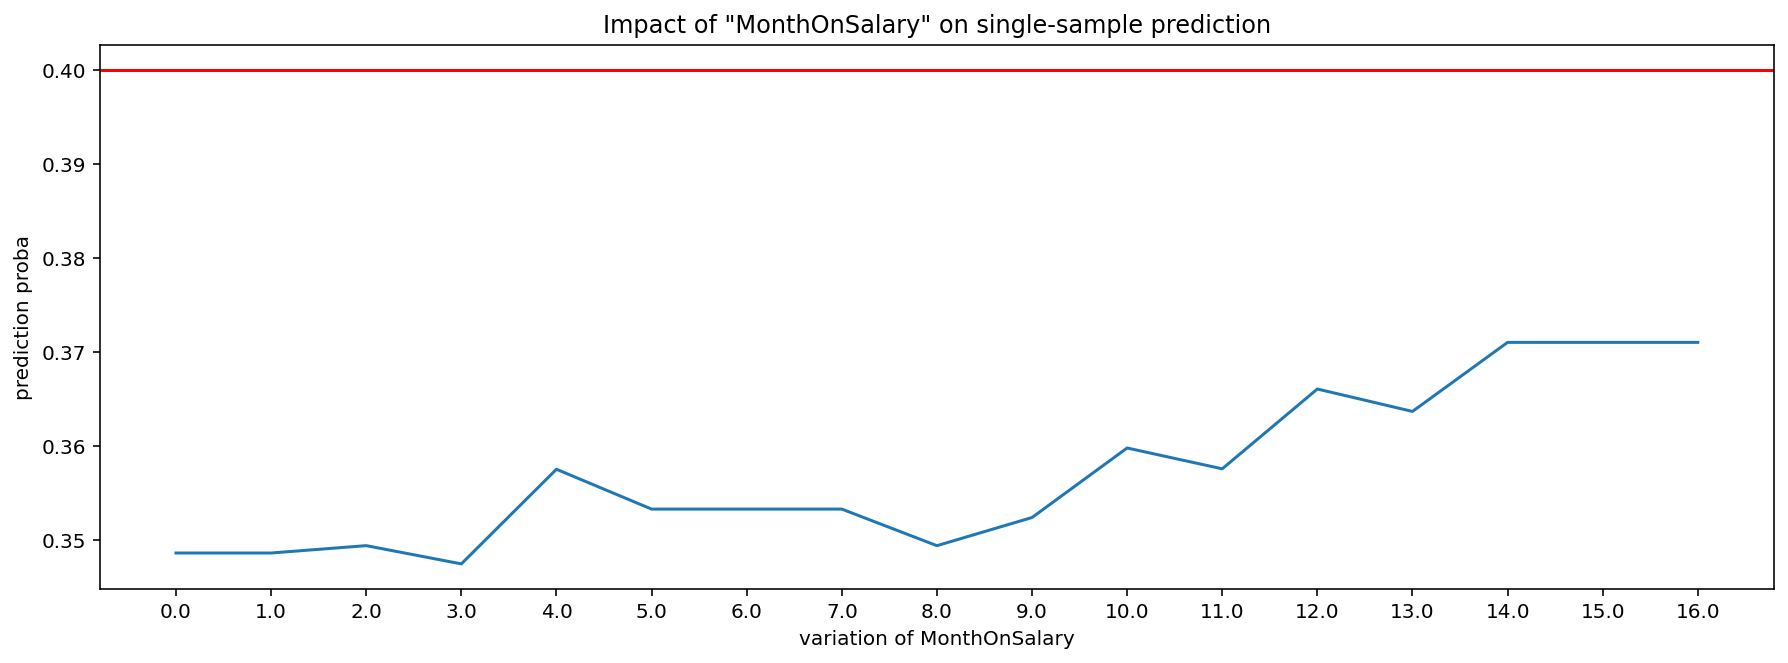

In [0]:
variate_single_sample_factor('MonthOnSalary', model, sample_df, np.linspace(-6, 10, 17))

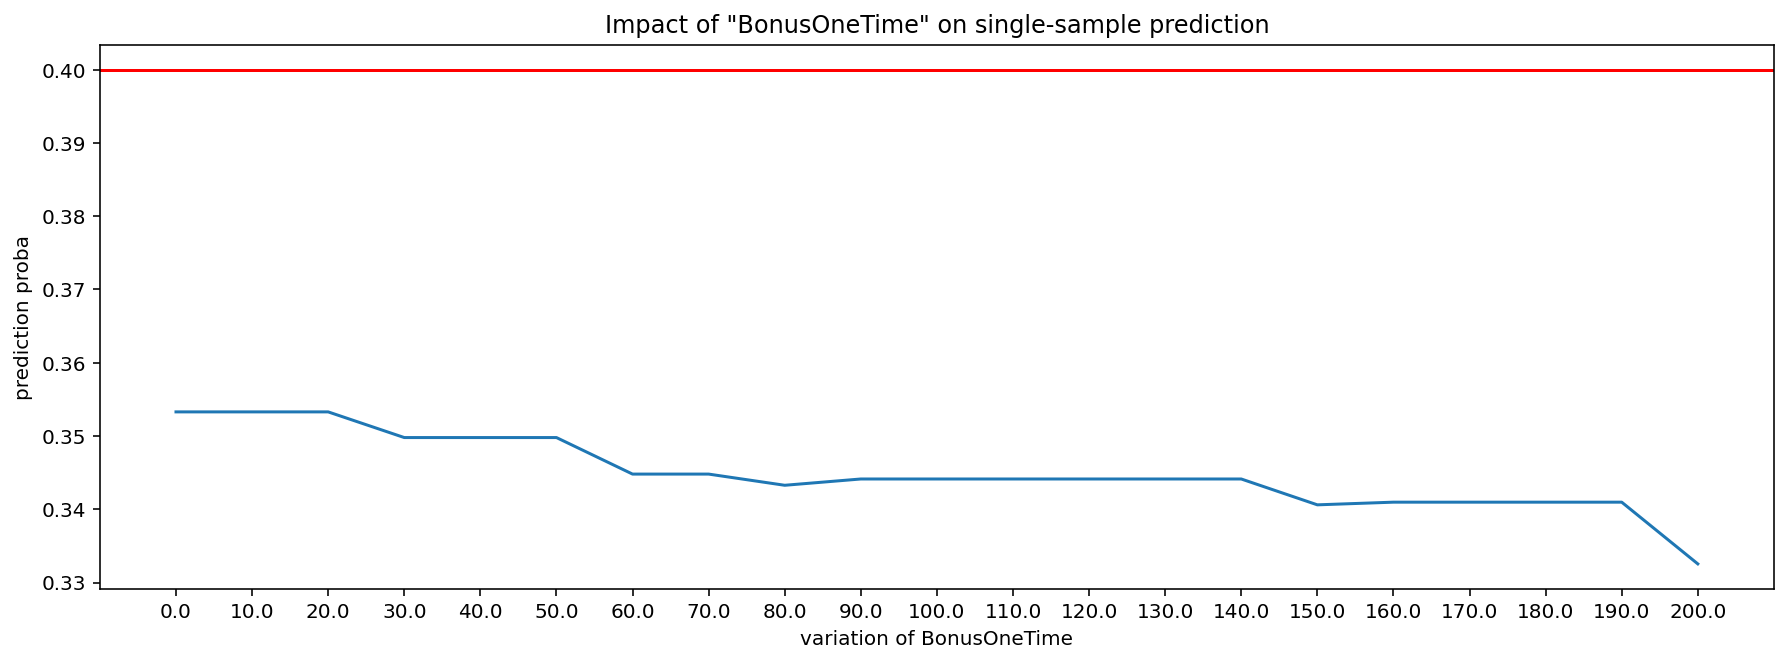

In [0]:
variate_single_sample_factor('BonusOneTime', model, sample_df, np.linspace(0, 200, 21))

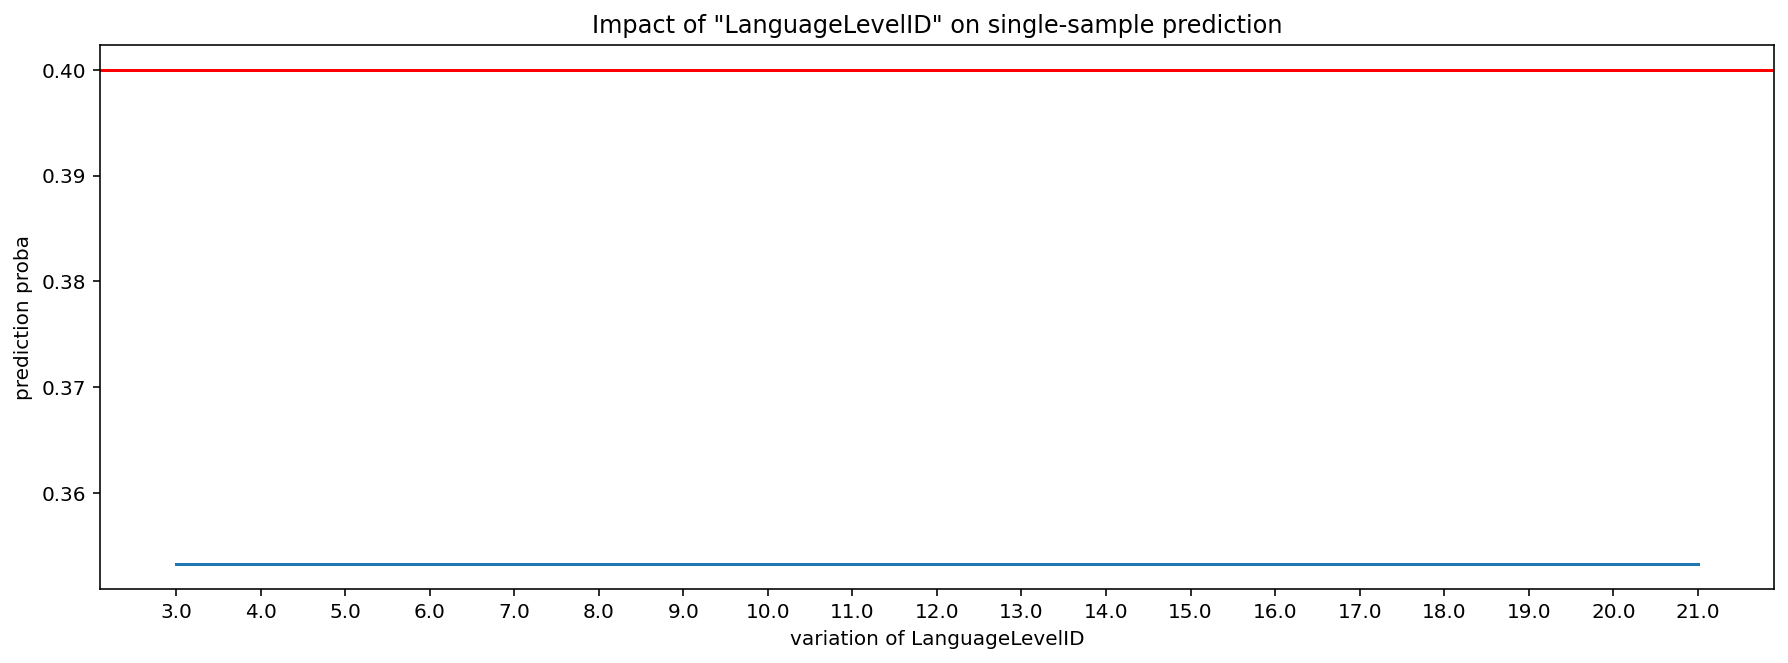

In [0]:
variate_single_sample_factor('LanguageLevelID', model, sample_df, np.linspace(-9, 9, 19))

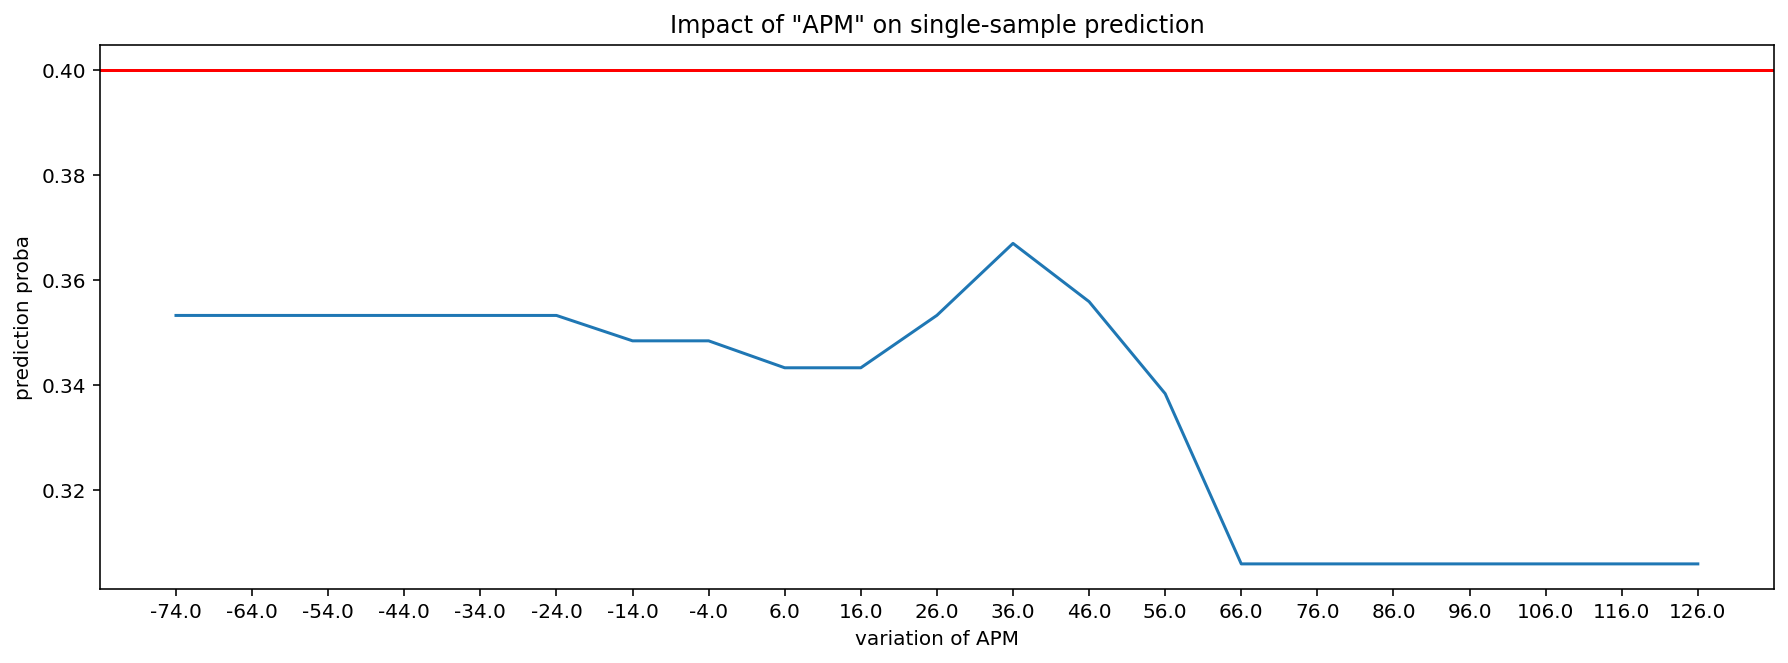

In [0]:
variate_single_sample_factor('APM', model, sample_df, np.linspace(-100, 100, 21))

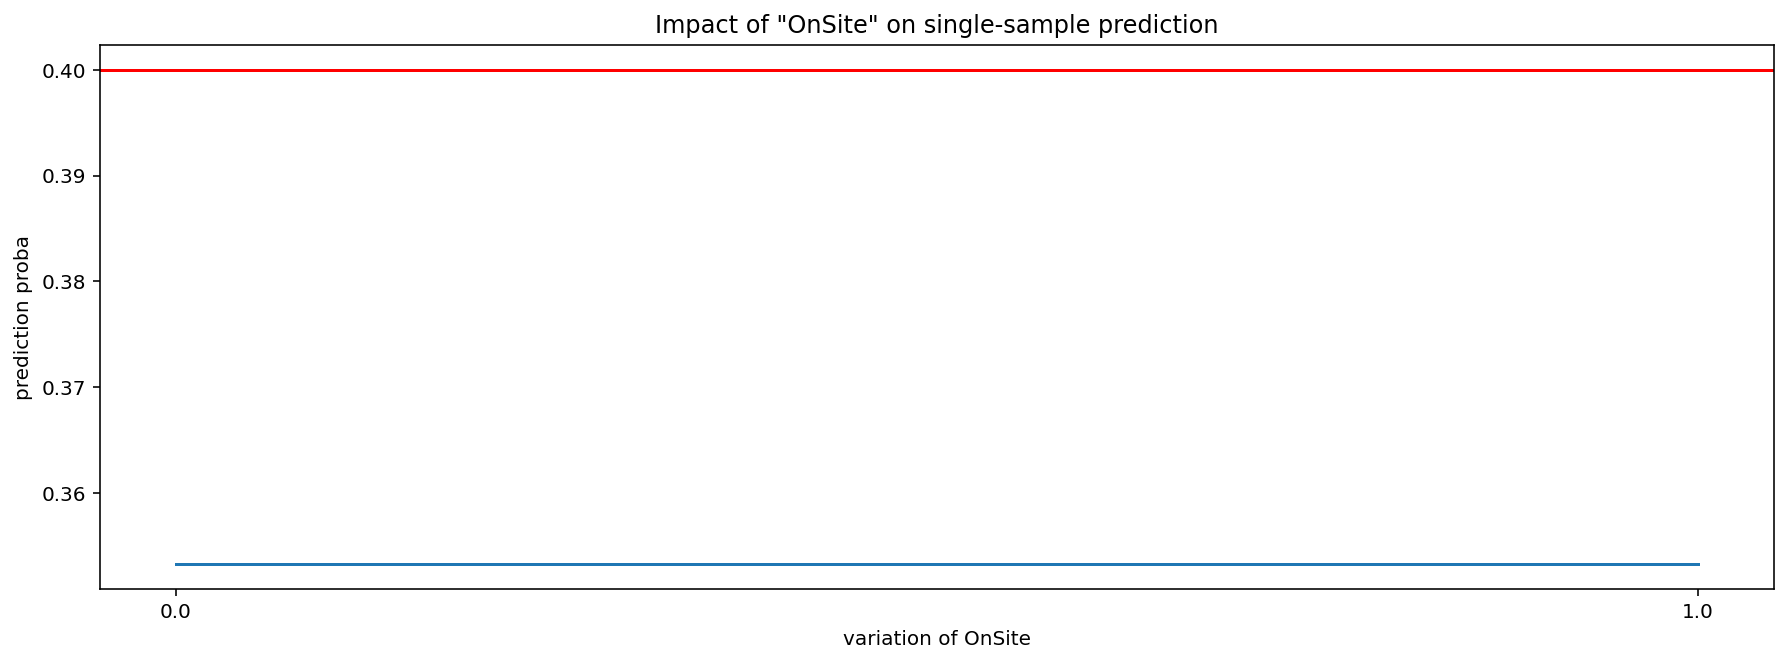

In [0]:
variate_single_sample_factor('OnSite', model, sample_df, np.linspace(0, 1, 2))

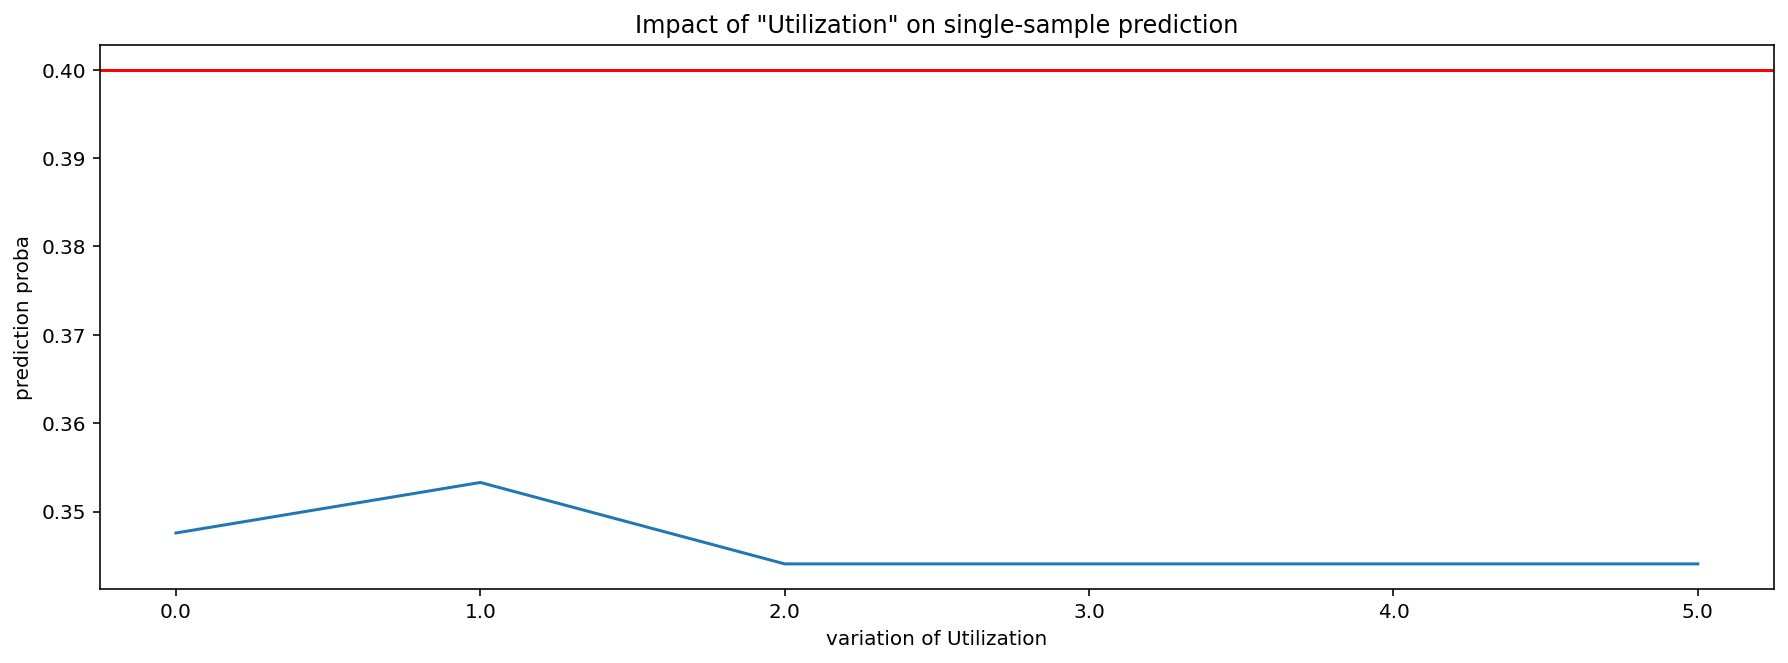

In [0]:
variate_single_sample_factor('Utilization', model, sample_df, np.linspace(-1, 4, 6))

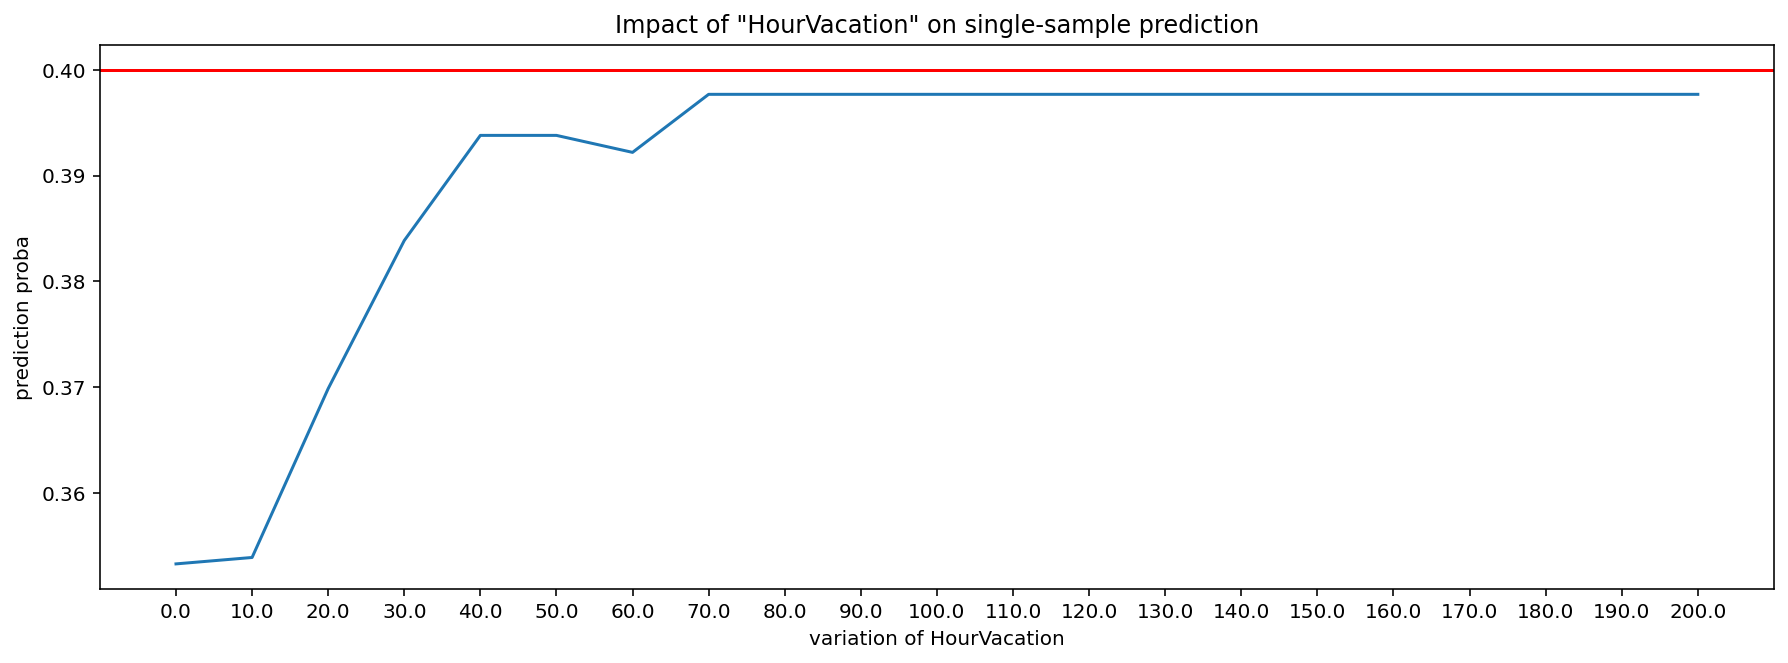

In [0]:
variate_single_sample_factor('HourVacation', model, sample_df, np.linspace(0, 200, 21))

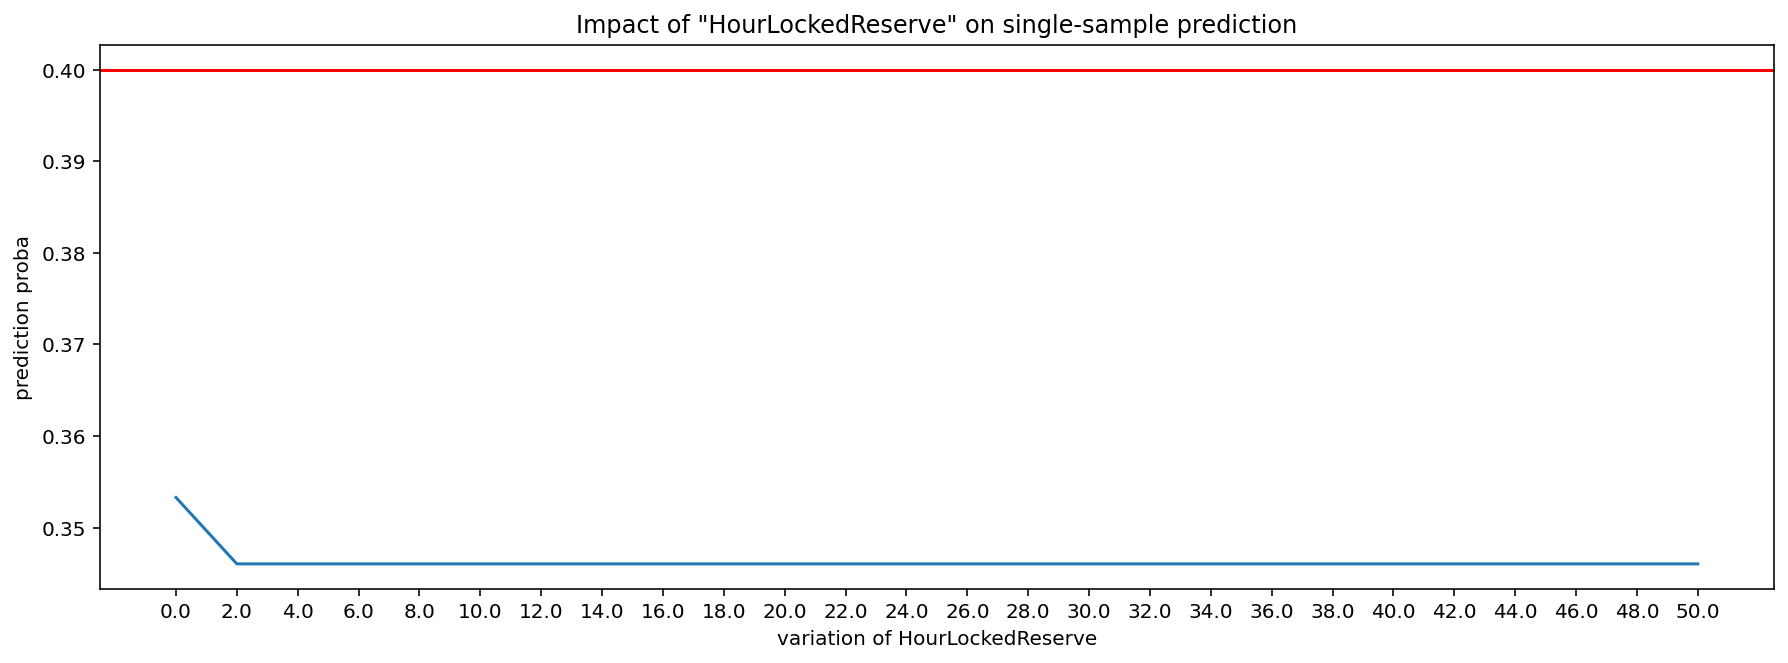

In [0]:
variate_single_sample_factor('HourLockedReserve', model, sample_df, np.linspace(0, 50, 26))

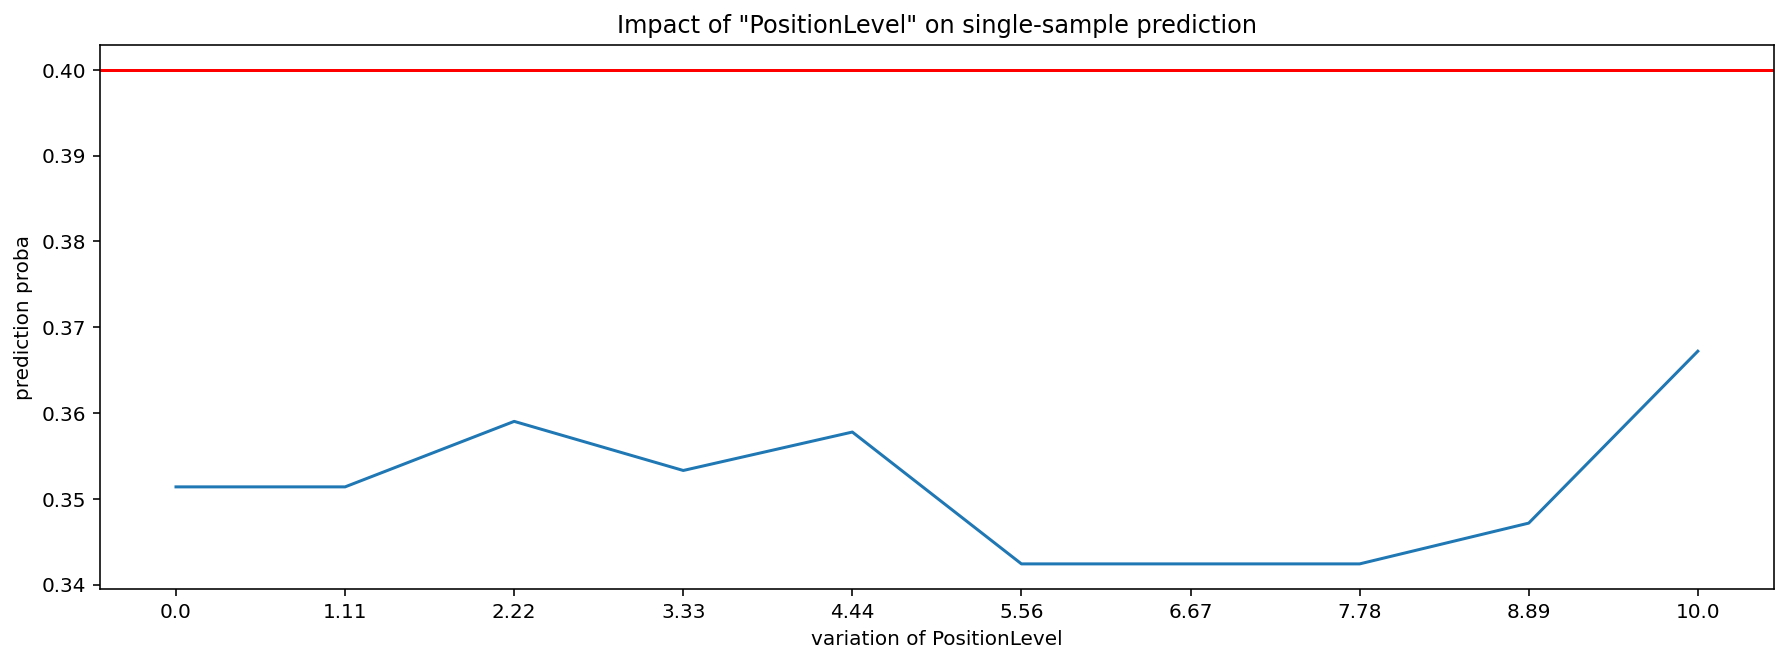

In [0]:
variate_single_sample_factor('PositionLevel', model, sample_df, np.linspace(-3, 7, 10))

### Резюме

1) Найбільший вплив на рішення моделі мають параметри experience_months, DevCenterID, WageGross, SBUID, HourMobileReserve, ProjectID, PositionID

2) За risk alerts можна брати HourMobileReserve > 30, DevCenterID > 13

3) Будь які бонуси є хорошим утримуючим фактором.